# Setup

In [1]:
import os
from pathlib import Path

os.chdir(Path.cwd().parent)
print("cwd is now:", Path.cwd())

cwd is now: /Users/ansonho/Documents/github/benchmark-stitching


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from data_loader import scores_df
from fit import fit_statistical_model


import seaborn as sns

sns.set()
sns.set_style("whitegrid")

# Custom color palette
custom_colors = [
    "#00A5A6",  # teal
    "#E03D90",  # pink
    "#FC6538",  # orange
    "#6A3ECB",  # purple
    "#0058DC",  # blue
    "#EA8D00",  # yellow
    "#B087F4",  # lightPurple
    "#279E27",  # green
    "#009AF1",  # lightBlue
    "#015D90",  # darkBlue
    "#EA4831",  # red
    "#E1C700",  # yellow2
    "#46FFFF",  # turquoise
    "#63F039",  # lightGreen
]

sns.set_palette(custom_colors)
colors = sns.color_palette()

# === Seaborn global settings ===
sns.set_theme(
    style="whitegrid",  # or "darkgrid", "ticks", "white"
    palette=custom_colors,  # your custom color palette
    context="notebook",  # scaling for labels/titles ("paper", "notebook", "talk", "poster")
)

# === Matplotlib global settings (rcParams) ===
plt.rcParams.update(
    {
        # Figure
        "figure.figsize": (8, 5),
        "figure.dpi": 120,
        # Axes
        "axes.titley": 1.02,
        "axes.titlesize": 14,
        "axes.titlelocation": "center",
        "axes.titlepad": 0,
        "axes.labelsize": 12,
        "axes.labelpad": 10,  # spacing between axis and label
        "axes.spines.top": False,
        "axes.spines.right": False,
        # Ticks
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        # tick marks size
        "xtick.major.size": 5,
        "ytick.major.size": 5,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        # tick visibility
        "xtick.top": False,
        "xtick.bottom": True,
        "ytick.left": True,
        "ytick.right": False,
        # Legend
        "legend.fontsize": 10,
        "legend.loc": "upper left",
        "legend.frameon": True,
        "legend.borderaxespad": 0,
        # Lines and markers
        "lines.linewidth": 2,
        "lines.markersize": 8,
        "lines.markeredgecolor": "auto",  # white outline (stroke)
        "lines.markeredgewidth": 0.5,
        # title alignment left
        # Error bars
        "errorbar.capsize": 3,
        # Font
        "font.family": "Arial",
        "font.sans-serif": ["DejaVu Sans"],
        # Grid
        "grid.alpha": 0.3,
        "grid.linestyle": "-",
        "grid.color": "lightgray",
    }
)

null performances after coercion: 0
after filter num benchmarks 2234
after merge with model versions 2234
after date filter (>= 2022-11-01) 2000
after merge with benchmark dates 2000
Original number of rows: 2000
Number of rows after aggregation: 1532


In [3]:
anchor_mode = "benchmark"  # "model", "benchmark"
anchor_benchmark = "Winogrande"
anchor_difficulty = 0
anchor_slope = 1
anchor_model1 = "claude-2.0"
anchor_model1_capability = 1.263943
anchor_model2 = "claude-3-opus-20240229"
anchor_model2_capability = 1.510032

df1, df_cm1, df_db1 = fit_statistical_model(
    scores_df,
    anchor_mode=anchor_mode,
    anchor_benchmark=anchor_benchmark,
    anchor_difficulty=anchor_difficulty,
    anchor_slope=anchor_slope,
    anchor_model1=anchor_model1,
    anchor_model1_capability=anchor_model1_capability,
    anchor_model2=anchor_model2,
    anchor_model2_capability=anchor_model2_capability,
)

df_cm1["date_obj"] = pd.to_datetime(df_cm1["date"])

`ftol` termination condition is satisfied.
Function evaluations 28, initial cost 5.3273e+01, final cost 3.7017e+00, first-order optimality 7.52e-04.


# Figure 0: Benchmark stitching diagram data (Section 1: Introduction)

In [4]:
main_plot_benchmarks = [
    "GPQA diamond",
    "FrontierMath-2025-02-28-Private",
    "Terminal Bench",
    "SWE-Bench verified",
    "Cybench",
    "MMLU",
]
main_plot_models = [
    "gemini-2.5-pro",
    "DeepSeek-R1",
    "claude-3-7-sonnet-20250219",
    "gpt-4o-2024-11-20",
    "gpt-5-2025-08-07_high",
    "claude-sonnet-4-5-20250929",
    "gpt-4.5-preview-2025-02-27",
    "Llama-3.1-405B",
    "grok-4-0709",
    "gpt-4-0314",
    "phi-2",
]

table = pd.concat(
    [
        df_db1[df_db1["benchmark_name"].isin(main_plot_benchmarks)][
            ["benchmark_name", "estimated_difficulty"]
        ].rename(columns={"benchmark_name": "item", "estimated_difficulty": "score"}),
        df_cm1[df_cm1["model"].isin(main_plot_models)][
            ["model", "estimated_capability"]
        ].rename(columns={"model": "item", "estimated_capability": "score"}),
    ],
    ignore_index=True,
)

ranked = table.sort_values("score", ascending=False).assign(
    rank=lambda df: range(1, len(df) + 1)
)[["rank", "item", "score"]]

display(ranked)

,rank,item,score
5,1,Cybench,3.067710
4,2,Terminal Bench,2.922714
3,3,FrontierMath-2025-02-28-Private,2.824560
6,4,gpt-5-2025-08-07_high,2.645294
7,5,grok-4-0709,2.505004
8,6,gemini-2.5-pro,2.442933
2,7,SWE-Bench verified,2.328978
9,8,DeepSeek-R1,2.176557
10,9,claude-sonnet-4-5-20250929,2.156811
11,10,gpt-4.5-preview-2025-02-27,2.094205


# Figure 1 and 14: Error bars (Section 3.1: Determining model capabilities and benchmark difficulties)

Change this line in `data_loader.py` to vary the amount of overlap.

`models_to_keep = model_benchmark_counts[model_benchmark_counts > 3].index # change number of benchmarks evaluated on, default 11`

In [4]:
import numpy as np
from scipy.optimize import minimize_scalar


def logistic(x):
    """Logistic function with clipping to prevent overflow."""
    x_clipped = np.clip(x, -500, 500)
    return 1.0 / (1.0 + np.exp(-x_clipped))


def compute_loss(predictions, actuals):
    """Compute sum of squared residuals."""
    return np.sum((predictions - actuals) ** 2)


def compute_capability_error_bars(df1, df_cm1, df_db1, loss_increase_threshold=0.05):
    """
    Compute error bars for model capabilities using binary search.

    For each C_m, we search for how far we can push C_m in either direction
    before causing a 5% increase in loss (on the subset that C_m influences).

    Parameters:
    -----------
    df1 : DataFrame
        The main data with model, benchmark, and performance columns
    df_cm1 : DataFrame
        Model capabilities with estimated_capability column
    df_db1 : DataFrame
        Benchmark parameters with estimated_difficulty and estimated_slope columns
    loss_increase_threshold : float
        The threshold for loss increase (default 0.05 for 5%)

    Returns:
    --------
    DataFrame with columns: model, estimated_capability, lower_bound, upper_bound, error_minus, error_plus
    """
    results = []

    # Create lookup dictionaries for efficiency
    capability_dict = dict(zip(df_cm1["model"], df_cm1["estimated_capability"]))
    difficulty_dict = dict(
        zip(df_db1["benchmark_name"], df_db1["estimated_difficulty"])
    )
    slope_dict = dict(zip(df_db1["benchmark_name"], df_db1["estimated_slope"]))

    for model_name in df_cm1["model"]:
        # Get subset of data for this model
        model_data = df1[df1["model"] == model_name].copy()

        if len(model_data) == 0:
            # No data for this model
            results.append(
                {
                    "model": model_name,
                    "estimated_capability": capability_dict[model_name],
                    "lower_bound": np.nan,
                    "upper_bound": np.nan,
                    "error_minus": np.nan,
                    "error_plus": np.nan,
                }
            )
            continue

        # Get original capability
        C_original = capability_dict[model_name]

        # Compute original loss for this model's data
        model_data["D"] = model_data["benchmark"].map(difficulty_dict)
        model_data["alpha"] = model_data["benchmark"].map(slope_dict)
        original_predictions = logistic(
            model_data["alpha"] * (C_original - model_data["D"])
        )
        original_loss = compute_loss(original_predictions, model_data["performance"])

        # Set acceptable loss threshold
        max_loss = original_loss * (1 + loss_increase_threshold)

        # Define loss function for a given capability
        def loss_for_capability(C_test):
            predictions = logistic(model_data["alpha"] * (C_test - model_data["D"]))
            return compute_loss(predictions, model_data["performance"])

        # Binary search for lower bound (decrease C_m)
        # Start with a reasonable search range
        search_range_lower = 5.0  # How far below to search
        C_lower = C_original - search_range_lower
        C_upper = C_original

        # Check if we need to expand the search range
        if loss_for_capability(C_lower) < max_loss:
            C_lower = C_original - 20.0  # Expand if needed

        # Binary search
        for _ in range(50):  # Max iterations
            C_mid = (C_lower + C_upper) / 2
            loss_mid = loss_for_capability(C_mid)

            if abs(loss_mid - max_loss) < 1e-6 * original_loss:
                break

            if loss_mid < max_loss:
                C_upper = C_mid
            else:
                C_lower = C_mid

        lower_bound = (C_lower + C_upper) / 2

        # Binary search for upper bound (increase C_m)
        C_lower = C_original
        C_upper = C_original + search_range_lower

        # Check if we need to expand the search range
        if loss_for_capability(C_upper) < max_loss:
            C_upper = C_original + 20.0

        # Binary search
        for _ in range(50):
            C_mid = (C_lower + C_upper) / 2
            loss_mid = loss_for_capability(C_mid)

            if abs(loss_mid - max_loss) < 1e-6 * original_loss:
                break

            if loss_mid < max_loss:
                C_lower = C_mid
            else:
                C_upper = C_mid

        upper_bound = (C_lower + C_upper) / 2

        results.append(
            {
                "model": model_name,
                "estimated_capability": C_original,
                "lower_bound": lower_bound,
                "upper_bound": upper_bound,
                "error_minus": C_original - lower_bound,
                "error_plus": upper_bound - C_original,
            }
        )

    return pd.DataFrame(results)


def compute_difficulty_error_bars(df1, df_cm1, df_db1, loss_increase_threshold=0.05):
    """
    Compute error bars for benchmark difficulties using binary search.

    For each D_b, after moving D_b, we re-fit α_b before evaluating the loss.

    Parameters:
    -----------
    df1 : DataFrame
        The main data with model, benchmark, and performance columns
    df_cm1 : DataFrame
        Model capabilities with estimated_capability column
    df_db1 : DataFrame
        Benchmark parameters with estimated_difficulty and estimated_slope columns
    loss_increase_threshold : float
        The threshold for loss increase (default 0.05 for 5%)

    Returns:
    --------
    DataFrame with columns: benchmark_name, estimated_difficulty, lower_bound, upper_bound, error_minus, error_plus
    """
    results = []

    # Create lookup dictionaries
    capability_dict = dict(zip(df_cm1["model"], df_cm1["estimated_capability"]))
    difficulty_dict = dict(
        zip(df_db1["benchmark_name"], df_db1["estimated_difficulty"])
    )
    slope_dict = dict(zip(df_db1["benchmark_name"], df_db1["estimated_slope"]))

    for benchmark_name in df_db1["benchmark_name"]:
        # Get subset of data for this benchmark
        bench_data = df1[df1["benchmark"] == benchmark_name].copy()

        if len(bench_data) == 0:
            results.append(
                {
                    "benchmark_name": benchmark_name,
                    "estimated_difficulty": difficulty_dict[benchmark_name],
                    "lower_bound": np.nan,
                    "upper_bound": np.nan,
                    "error_minus": np.nan,
                    "error_plus": np.nan,
                }
            )
            continue

        # Get original difficulty and slope
        D_original = difficulty_dict[benchmark_name]
        alpha_original = slope_dict[benchmark_name]

        # Add model capabilities to benchmark data
        bench_data["C"] = bench_data["model"].map(capability_dict)

        # Compute original loss
        original_predictions = logistic(alpha_original * (bench_data["C"] - D_original))
        original_loss = compute_loss(original_predictions, bench_data["performance"])

        max_loss = original_loss * (1 + loss_increase_threshold)

        def refit_alpha_and_compute_loss(D_test):
            """
            For a given D_test, find the optimal alpha and return the loss.
            """

            def loss_for_alpha(alpha):
                if alpha <= 0:
                    return 1e10  # Penalty for invalid alpha
                predictions = logistic(alpha * (bench_data["C"] - D_test))
                return compute_loss(predictions, bench_data["performance"])

            # Optimize alpha (constrained to be positive)
            result = minimize_scalar(
                loss_for_alpha, bounds=(0.01, 20.0), method="bounded"
            )
            return result.fun

        # Binary search for lower bound
        search_range = 5.0
        D_lower = D_original - search_range
        D_upper = D_original

        if refit_alpha_and_compute_loss(D_lower) < max_loss:
            D_lower = D_original - 20.0

        for _ in range(50):
            D_mid = (D_lower + D_upper) / 2
            loss_mid = refit_alpha_and_compute_loss(D_mid)

            if abs(loss_mid - max_loss) < 1e-6 * original_loss:
                break

            if loss_mid < max_loss:
                D_upper = D_mid
            else:
                D_lower = D_mid

        lower_bound = (D_lower + D_upper) / 2

        # Binary search for upper bound
        D_lower = D_original
        D_upper = D_original + search_range

        if refit_alpha_and_compute_loss(D_upper) < max_loss:
            D_upper = D_original + 20.0

        for _ in range(50):
            D_mid = (D_lower + D_upper) / 2
            loss_mid = refit_alpha_and_compute_loss(D_mid)

            if abs(loss_mid - max_loss) < 1e-6 * original_loss:
                break

            if loss_mid < max_loss:
                D_lower = D_mid
            else:
                D_upper = D_mid

        upper_bound = (D_lower + D_upper) / 2

        results.append(
            {
                "benchmark_name": benchmark_name,
                "estimated_difficulty": D_original,
                "lower_bound": lower_bound,
                "upper_bound": upper_bound,
                "error_minus": D_original - lower_bound,
                "error_plus": upper_bound - D_original,
            }
        )

    return pd.DataFrame(results)


# Compute error bars
print("Computing error bars for model capabilities...")
capability_errors = compute_capability_error_bars(
    df1, df_cm1, df_db1, loss_increase_threshold=0.05
)

print("\nComputing error bars for benchmark difficulties...")
difficulty_errors = compute_difficulty_error_bars(
    df1, df_cm1, df_db1, loss_increase_threshold=0.05
)

print("\nDone! Error bars computed.")
print(f"\nSample capability errors:")
print(capability_errors.head(10))
print(f"\nSample difficulty errors:")
print(difficulty_errors.head(10))

Computing error bars for model capabilities...

Computing error bars for benchmark difficulties...

Done! Error bars computed.

Sample capability errors:
                                     model  estimated_capability  lower_bound  \
0                gpt-5-pro-2025-10-06_high              2.596726     2.588714   
1                             gpt-5.1_high              2.581481     2.564769   
2                    gpt-5-2025-08-07_high              2.578840     2.559075   
3  gemini-2.5-deep-think-2025-08-01-webapp              2.557153     2.554227   
4                  gpt-5-2025-08-07_medium              2.535450     2.504444   
5                 o3-pro-2025-06-10_medium              2.505497     2.483499   
6                           gpt-5.1_medium              2.499577     2.487944   
7                   o3-pro-2025-06-10_high              2.486845     2.485770   
8                              gpt-5-codex              2.464977     2.459460   
9                       o3-2025-04-1

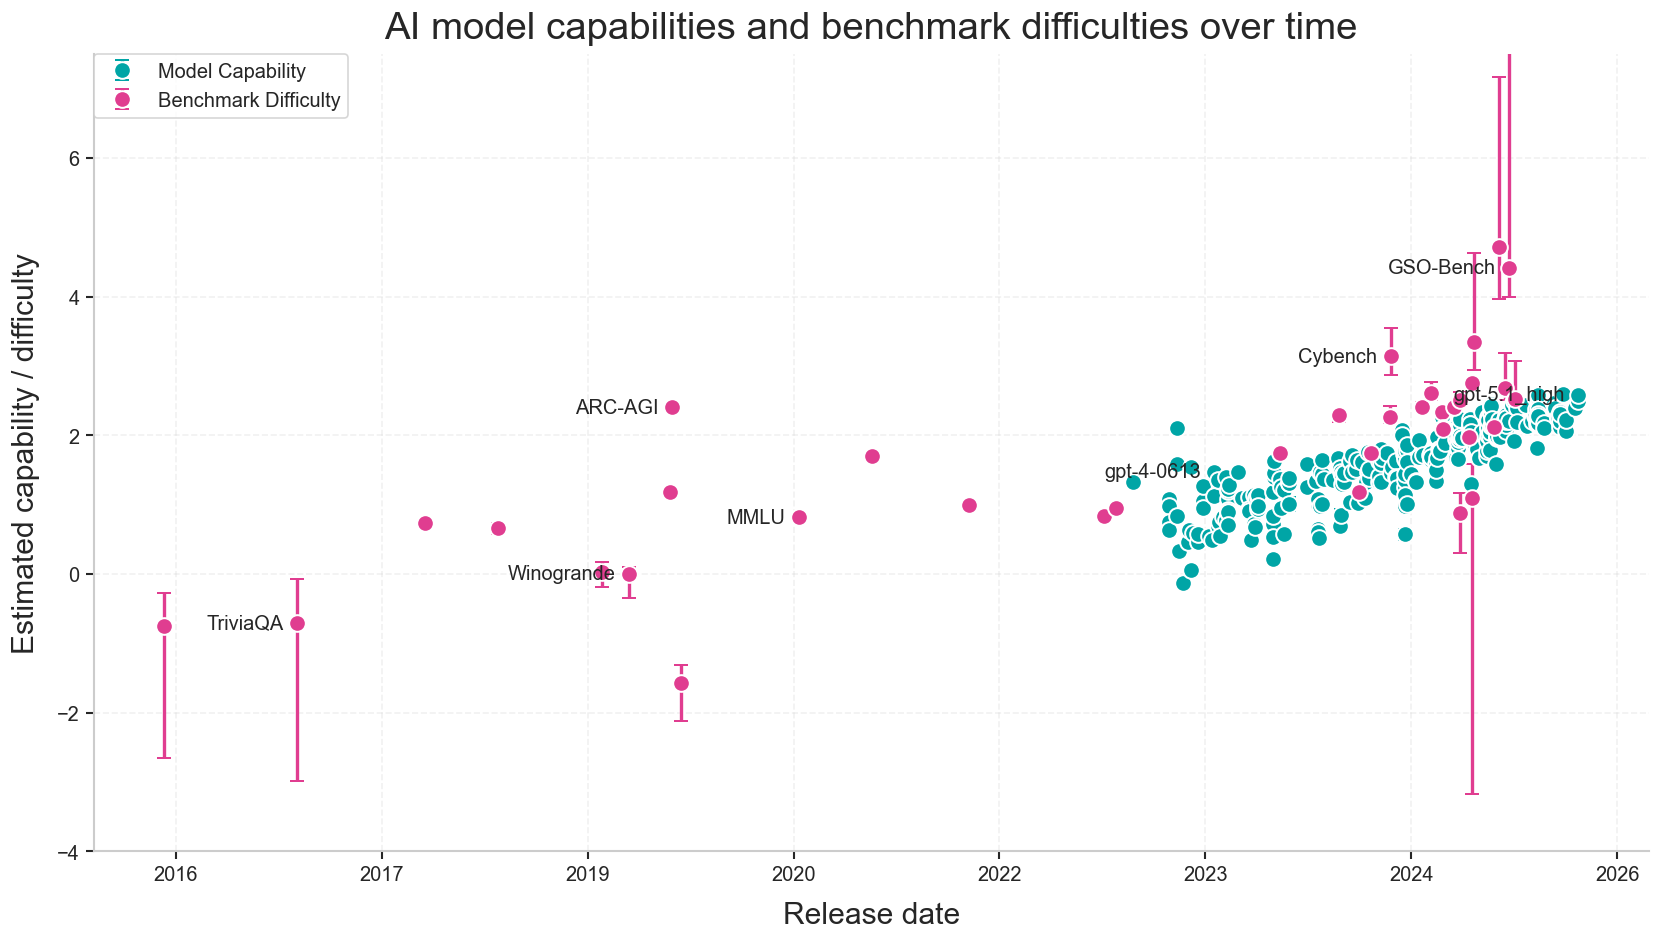

In [ ]:
# ── PLOT WITH ERROR BARS ──────────────────────────────────────────────────
# Merge error bars with the original data
cap_df_with_errors = df_cm1.merge(
    capability_errors[["model", "error_minus", "error_plus"]], on="model", how="left"
)
bench_df_with_errors = df_db1.merge(
    difficulty_errors[["benchmark_name", "error_minus", "error_plus"]],
    on="benchmark_name",
    how="left",
)

# Prepare data
cap_df_with_errors["date_obj"] = pd.to_datetime(cap_df_with_errors["date"])
cap_df_with_errors.sort_values("date_obj", inplace=True, ignore_index=True)
cap_dates_num = mdates.date2num(cap_df_with_errors["date_obj"])
cap_values = cap_df_with_errors["estimated_capability"]

bench_df_with_errors["date_obj"] = pd.to_datetime(
    bench_df_with_errors["benchmark_release_date"]
)
bench_df_with_errors.sort_values("date_obj", inplace=True, ignore_index=True)
bench_dates_num = mdates.date2num(bench_df_with_errors["date_obj"])
bench_values = bench_df_with_errors["estimated_difficulty"]

# Create the plot
fig, ax = plt.subplots(figsize=(14, 8))

# Plot with error bars, increase label size and legend size
ax.errorbar(
    cap_dates_num,
    cap_values,
    yerr=[cap_df_with_errors["error_minus"], cap_df_with_errors["error_plus"]],
    fmt="o",
    markersize=10,  # Increased marker size a bit
    capsize=4,
    capthick=1.5,
    markeredgewidth=1.2,
    markeredgecolor="white",
    color=colors[0],
    ecolor=colors[0],
    alpha=1,
    label="Model Capability",  # Capitalized and spaced for more clarity
)

ax.errorbar(
    bench_dates_num,
    bench_values,
    yerr=[bench_df_with_errors["error_minus"], bench_df_with_errors["error_plus"]],
    fmt="o",
    markersize=10,  # Increased marker size a bit
    capsize=4,
    capthick=1.5,
    markeredgewidth=1.2,
    markeredgecolor="white",
    color=colors[1],
    ecolor=colors[1],
    alpha=1,
    label="Benchmark Difficulty",  # Capitalized and spaced for more clarity
)

# Increase fontsize of the legend labels
legend = ax.legend(fontsize=16, title_fontsize=18)
# Annotate selected points (same as before)
annotate_models = {
    # "gpt-5-2025-08-07_high",
    # "claude-opus-4-20250514_32K",
    # "grok-4-0709",
    "gpt-4-0613",
    # "claude-3-opus-20240229",
    # "gemini-2.5-pro-exp-03-25",
    # "o1-preview-2024-09-12",
    "gpt-5.1_high"
}


annotate_benchmarks = {
    "MMLU",
    "Winogrande",
    # "GPQA diamond",
    # "OSWorld",
    "GSO-Bench",
    "Cybench",
    # "Terminal Bench",
    "TriviaQA",
    "ARC-AGI"
}


# helper for left/right non-overlapping placement
def side_offset(i, x_offset=8, y_offset=0):
    """Alternate left/right; return (dx, ha, va, dy)."""
    if i % 2 == 0:
        # place RIGHT of point
        return (x_offset, "left", "center", y_offset)
    else:
        # place LEFT of point
        return (-x_offset, "right", "center", -y_offset)


# Annotate selected models
for i, (d, y, name) in enumerate(
    zip(cap_dates_num, cap_values, cap_df_with_errors["model"])
):
    if name not in annotate_models:
        continue

    dx, ha, va, dy = side_offset(i)
    ax.annotate(
        name,
        xy=(d, y),
        xytext=(dx, dy),
        textcoords="offset points",
        ha=ha,
        va=va,
        fontsize=12,
    )


# Annotate selected benchmarks
for i, (d, y, name) in enumerate(
    zip(bench_dates_num, bench_values, bench_df_with_errors["benchmark_name"])
):
    if name not in annotate_benchmarks:
        continue

    dx, ha, va, dy = side_offset(i)
    ax.annotate(
        name,
        xy=(d, y),
        xytext=(dx, dy),
        textcoords="offset points",
        ha=ha,
        va=va,
        fontsize=12,
    )

# Axes cosmetics
ax.set_xlabel("Release date", fontsize=18)
ax.set_ylabel("Estimated capability / difficulty", fontsize=18)
ax.set_title("AI model capabilities and benchmark difficulties over time", fontsize=23)

ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

ax.tick_params(axis="x", rotation=0)

min_y = -4
max_y = 7.5
ax.set_ylim(min_y, max_y)

ax.grid(True, linestyle="--", alpha=0.3)
ax.legend(fontsize=12)

plt.tight_layout()
# plt.savefig("outputs/model_fit/capabilities_and_benchmarks_with_error_bars_g1.pdf")
plt.savefig("outputs/model_fit/capabilities_and_benchmarks_with_error_bars.pdf")
plt.savefig("outputs/model_fit/capabilities_and_benchmarks_with_error_bars.svg", format="svg")
# plt.savefig("outputs/figures/figure-1.svg", format="svg")

plt.show()

# Figure 2: Model capability and benchmark difficulty rankings (Section 3.1 Determining model capabilities and benchmark difficulties)

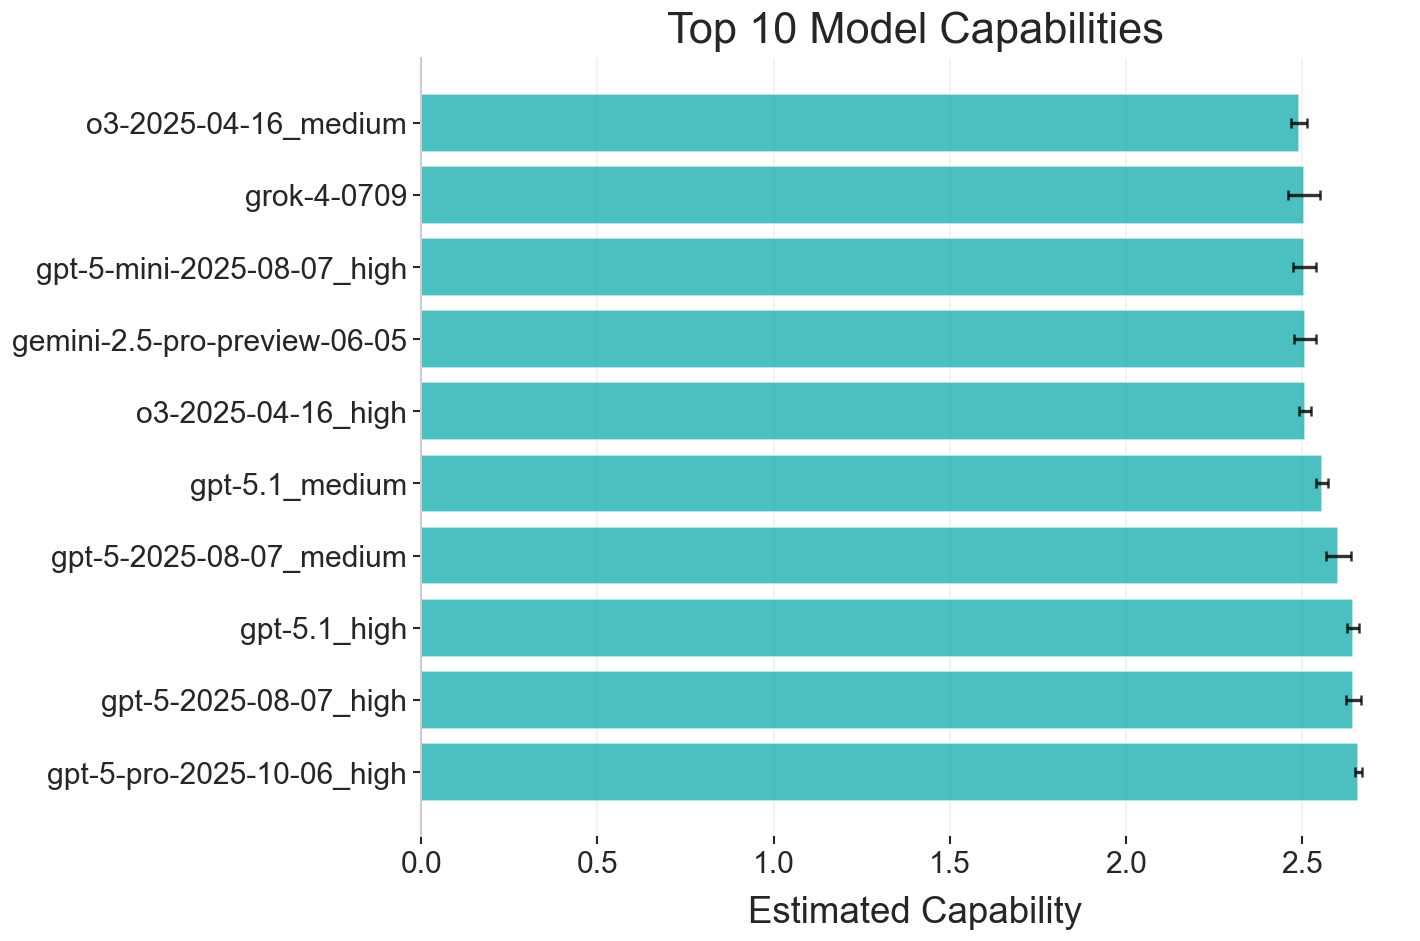


Top 10 Models by Capability:
 1. gpt-5-pro-2025-10-06_high                     2.6592 (±0.0096, +0.0103)
 2. gpt-5-2025-08-07_high                         2.6453 (±0.0213, +0.0218)
 3. gpt-5.1_high                                  2.6446 (±0.0173, +0.0178)
 4. gpt-5-2025-08-07_medium                       2.6028 (±0.0343, +0.0354)
 5. gpt-5.1_medium                                2.5567 (±0.0164, +0.0172)
 6. o3-2025-04-16_high                            2.5091 (±0.0165, +0.0169)
 7. gemini-2.5-pro-preview-06-05                  2.5084 (±0.0301, +0.0305)
 8. gpt-5-mini-2025-08-07_high                    2.5061 (±0.0315, +0.0324)
 9. grok-4-0709                                   2.5050 (±0.0455, +0.0473)
10. o3-2025-04-16_medium                          2.4904 (±0.0230, +0.0234)


In [7]:
# Model Capabilities Ranking - Top 20 Models
fig, ax = plt.subplots(figsize=(12, 8))

# Get data with valid capabilities
df_capabilities_clean = df_cm1.dropna(subset=["date", "estimated_capability"])
top_models = df_capabilities_clean.nlargest(10, "estimated_capability")

# Merge with error bars
top_models_with_errors = top_models.merge(
    capability_errors[["model", "error_minus", "error_plus"]], on="model", how="left"
)

y_pos = np.arange(len(top_models_with_errors))

# Create horizontal bar chart with error bars
ax.barh(y_pos, top_models_with_errors["estimated_capability"], alpha=0.7)
ax.errorbar(
    top_models_with_errors["estimated_capability"],
    y_pos,
    xerr=[top_models_with_errors["error_minus"], top_models_with_errors["error_plus"]],
    fmt="none",
    ecolor="black",
    capsize=3,
    capthick=1.5,
    alpha=0.8,
)

ax.set_yticks(y_pos)
ax.set_yticklabels(top_models_with_errors["model"], fontsize=18)
ax.tick_params(axis="x", labelsize=18)

ax.grid(False, axis="y")
ax.spines["bottom"].set_visible(False)

ax.set_xlabel("Estimated Capability", fontsize=22)
ax.set_title("Top 10 Model Capabilities", fontsize=26)
ax.grid(True, alpha=0.3, axis="x")

plt.tight_layout()
plt.savefig("outputs/model_fit/model_capabilities_ranking.pdf", dpi=300, bbox_inches="tight")
plt.savefig("outputs/model_fit/model_capabilities_ranking.svg", format="svg")
# plt.savefig("outputs/figures/figure-2a.svg", format="svg")

plt.show()

print("\nTop 10 Models by Capability:")
for i, (idx, row) in enumerate(top_models_with_errors.iterrows()):
    print(
        f"{i+1:2d}. {row['model']:45s} {row['estimated_capability']:.4f} (±{row['error_minus']:.4f}, +{row['error_plus']:.4f})"
    )

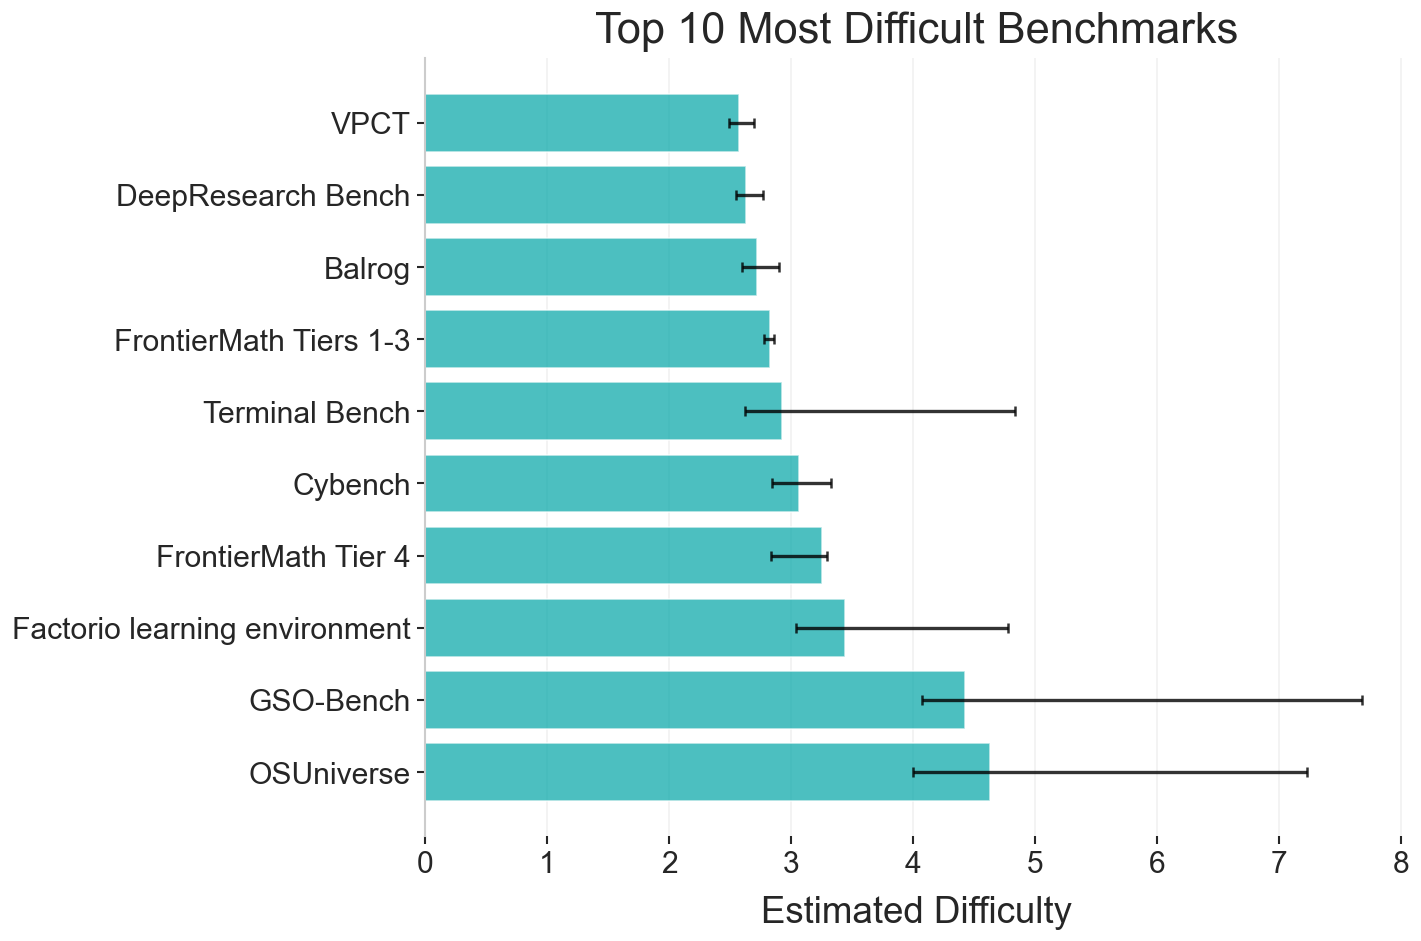


Top 10 Most Difficult Benchmarks:
 1. OSUniverse                                    4.6280 (±0.6297, +2.6010)
 2. GSO-Bench                                     4.4259 (±0.3570, +3.2509)
 3. Factorio learning environment                 3.4378 (±0.3978, +1.3396)
 4. FrontierMath-Tier-4-2025-07-01-Private        3.2521 (±0.4161, +0.0428)
 5. Cybench                                       3.0677 (±0.2240, +0.2586)
 6. Terminal Bench                                2.9227 (±0.3015, +1.9112)
 7. FrontierMath-2025-02-28-Private               2.8246 (±0.0491, +0.0335)
 8. Balrog                                        2.7226 (±0.1287, +0.1784)
 9. DeepResearch Bench                            2.6268 (±0.0760, +0.1409)
10. VPCT                                          2.5717 (±0.0809, +0.1229)


In [8]:
# Benchmark Difficulties Ranking - Top 15 Most Difficult Benchmarks
fig, ax = plt.subplots(figsize=(12, 8))

# Sort benchmarks by difficulty and get top 15
df_benchmarks_sorted = df_db1.sort_values("estimated_difficulty", ascending=True)
top_difficult = df_benchmarks_sorted.nlargest(10, "estimated_difficulty")

# Merge with error bars
top_difficult_with_errors = top_difficult.merge(
    difficulty_errors[["benchmark_name", "error_minus", "error_plus"]],
    on="benchmark_name",
    how="left",
)

y_pos = np.arange(len(top_difficult_with_errors))

# Create horizontal bar chart with error bars
ax.barh(y_pos, top_difficult_with_errors["estimated_difficulty"], alpha=0.7)
ax.errorbar(
    top_difficult_with_errors["estimated_difficulty"],
    y_pos,
    xerr=[
        top_difficult_with_errors["error_minus"],
        top_difficult_with_errors["error_plus"],
    ],
    fmt="none",
    ecolor="black",
    capsize=3,
    capthick=1.5,
    alpha=0.8,
)

ax.set_yticks(y_pos)
frontier_label_map = {
    "FrontierMath-2025-02-28-Private": "FrontierMath Tiers 1-3",
    "FrontierMath-Tier-4-2025-07-01-Private": "FrontierMath Tier 4",
}
display_names = top_difficult_with_errors["benchmark_name"].replace(frontier_label_map)
ax.set_yticklabels(display_names, fontsize=18)
# ax.set_yticklabels(top_difficult_with_errors["benchmark_name"], fontsize=18)
ax.tick_params(axis="x", labelsize=18)
ax.set_xlabel("Estimated Difficulty", fontsize=22)
ax.set_title("Top 10 Most Difficult Benchmarks", fontsize=26)
ax.grid(True, alpha=0.3, axis="x")
ax.grid(False, axis="y")
ax.spines["bottom"].set_visible(False)
plt.tight_layout()
plt.savefig("outputs/model_fit/benchmark_difficulties_ranking.pdf", dpi=300, bbox_inches="tight")
plt.savefig("outputs/model_fit/benchmark_difficulties_ranking.svg", format="svg")
# plt.savefig("outputs/figures/figure-2b.svg", format="svg")

plt.show()

print("\nTop 10 Most Difficult Benchmarks:")
for i, (idx, row) in enumerate(top_difficult_with_errors.iterrows()):
    print(
        f"{i+1:2d}. {row['benchmark_name']:45s} {row['estimated_difficulty']:.4f} (±{row['error_minus']:.4f}, +{row['error_plus']:.4f})"
    )

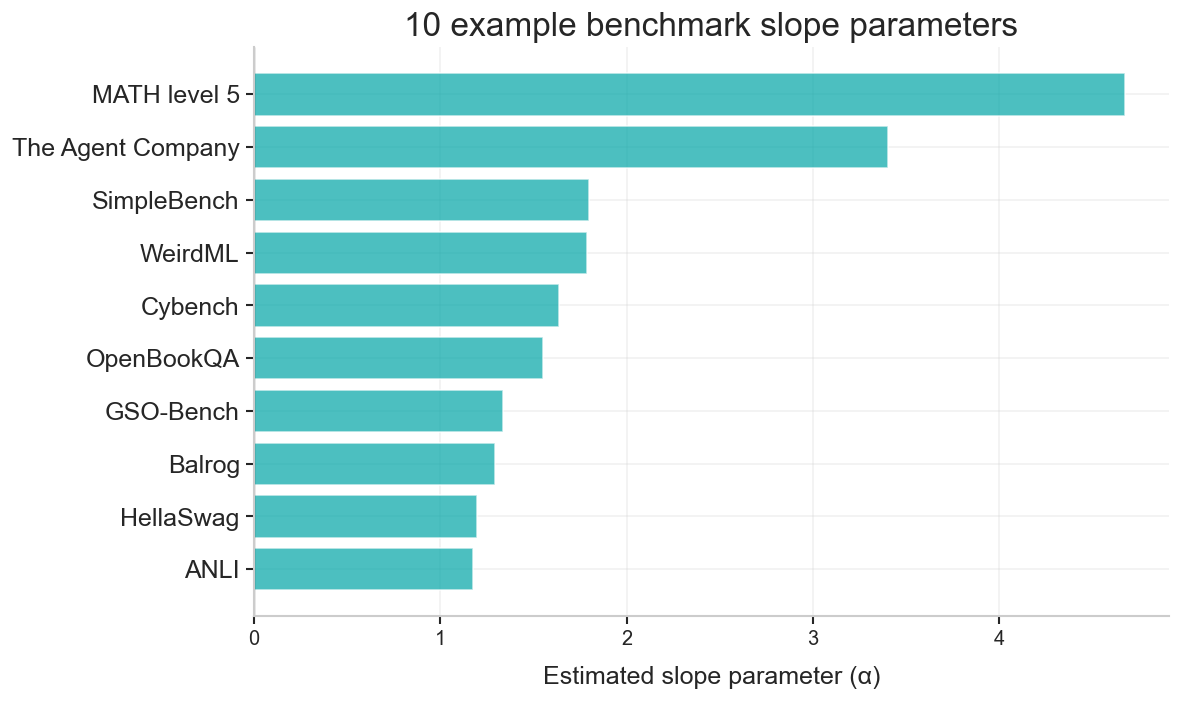


10 Example benchmark slope parameters
 1. ANLI                                          1.1732
 2. HellaSwag                                     1.1994
 3. Balrog                                        1.2950
 4. GSO-Bench                                     1.3372
 5. OpenBookQA                                    1.5507
 6. Cybench                                       1.6396
 7. WeirdML                                       1.7874
 8. SimpleBench                                   1.7972
 9. The Agent Company                             3.4042
10. MATH level 5                                  4.6767


In [9]:
# Example Benchmark Slopes - Choose specific benchmarks or N random ones
import numpy as np

# Configuration
benchmark_names = None  # Set to list of benchmark names, e.g., ['MMLU', 'GPQA diamond', 'ARC AI2'], or None for random
N_random = (
    10  # Number of random benchmarks to select (only used if benchmark_names is None)
)

# Select benchmarks
if benchmark_names is not None:
    selected_df = df_db1[df_db1["benchmark_name"].isin(benchmark_names)]
else:
    selected_df = df_db1.sample(n=min(N_random, len(df_db1)), random_state=42)

# Sort by slope for better visualization
selected_df = selected_df.sort_values("estimated_slope", ascending=True)

# Create bar chart
fig, ax = plt.subplots(figsize=(10, max(6, len(selected_df) * 0.4)))
y_pos = np.arange(len(selected_df))

ax.barh(y_pos, selected_df["estimated_slope"], alpha=0.7)
ax.set_yticks(y_pos)
ax.set_yticklabels(selected_df["benchmark_name"], fontsize=15)
ax.set_xlabel("Estimated slope parameter (α)", fontsize=15)
ax.set_title(f"{len(selected_df)} example benchmark slope parameters", fontsize=20)
ax.grid(True, alpha=0.3, axis="x")
ax.axvline(x=0, color="black", linestyle="-", alpha=0.5, linewidth=0.8)

plt.tight_layout()
plt.savefig(
    "outputs/model_fit/example_benchmark_slope_parameters.pdf",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

# Print values
print(f"\n{len(selected_df)} Example benchmark slope parameters")
for i, (idx, row) in enumerate(selected_df.iterrows()):
    print(f"{i+1:2d}. {row['benchmark_name']:45s} {row['estimated_slope']:.4f}")

# Figure 3: Map to METR time horizon (Section 3.1.1 Interpreting estimated capabilities and difficulties)

In [10]:
df_metr = pd.read_csv("data/external_benchmark_metr.csv")
columns = {
    "Model version": "model",
    "Time horizon": "time_horizon",
}
df_metr.rename(columns=columns, inplace=True)
df_metr.head()

,id,model,CI_high,CI_low,time_horizon,Source,Source link,average_score,Notes
0,rec3I5CcPGjF3Riat,claude-3-5-sonnet-20240620,34.472569,9.492954,18.216830,METR - Measuring AI Ability to Complete Long T...,https://metr.org/blog/2025-03-19-measuring-ai-...,0.476797,NaN
1,recM2JJhzA3vJAZoZ,claude-3-5-sonnet-20241022,56.988170,13.345031,28.983512,METR - Measuring AI Ability to Complete Long T...,https://metr.org/blog/2025-03-19-measuring-ai-...,0.527010,NaN
2,recqRojHxRU5ySXWq,claude-3-7-sonnet-20250219_16K,89.828760,27.763038,54.226342,METR - Measuring AI Ability to Complete Long T...,https://metr.org/blog/2025-03-19-measuring-ai-...,0.599681,NaN
3,recyvUC4eTQ5SK6Gr,claude-3-opus-20240229,12.951308,2.743525,6.422825,METR - Measuring AI Ability to Complete Long T...,https://metr.org/blog/2025-03-19-measuring-ai-...,0.377459,NaN
4,recuz9bui4PgiPuGH,claude-opus-4-1-20250805_16K,192.232318,53.816764,105.499169,METR - Measuring AI Ability to Complete Long T...,https://metr.org/blog/2025-03-19-measuring-ai-...,0.668069,NaN


Original df_metr rows: 30
Original df_cm1 rows: 179
Combined df rows (models in both): 23

Models in combined dataset:
                             model  time_horizon  estimated_capability
0       claude-3-5-sonnet-20240620     18.216830              1.805797
1       claude-3-5-sonnet-20241022     28.983512              1.970712
2   claude-3-7-sonnet-20250219_16K     54.226342              2.170476
3           claude-3-opus-20240229      6.422825              1.669307
4     claude-opus-4-1-20250805_16K    105.499169              2.255795
5       claude-opus-4-20250514_16K     79.862937              2.262734
6     claude-sonnet-4-20250514_16K     67.705892              2.250902
7                      DeepSeek-R1     26.932599              2.176557
8                 DeepSeek-R1-0528     31.167847              2.260334
9                      DeepSeek-V3     18.472532              1.925455
10                DeepSeek-V3-0324     23.117113              2.086620
11    gemini-2.5-pro-preview-

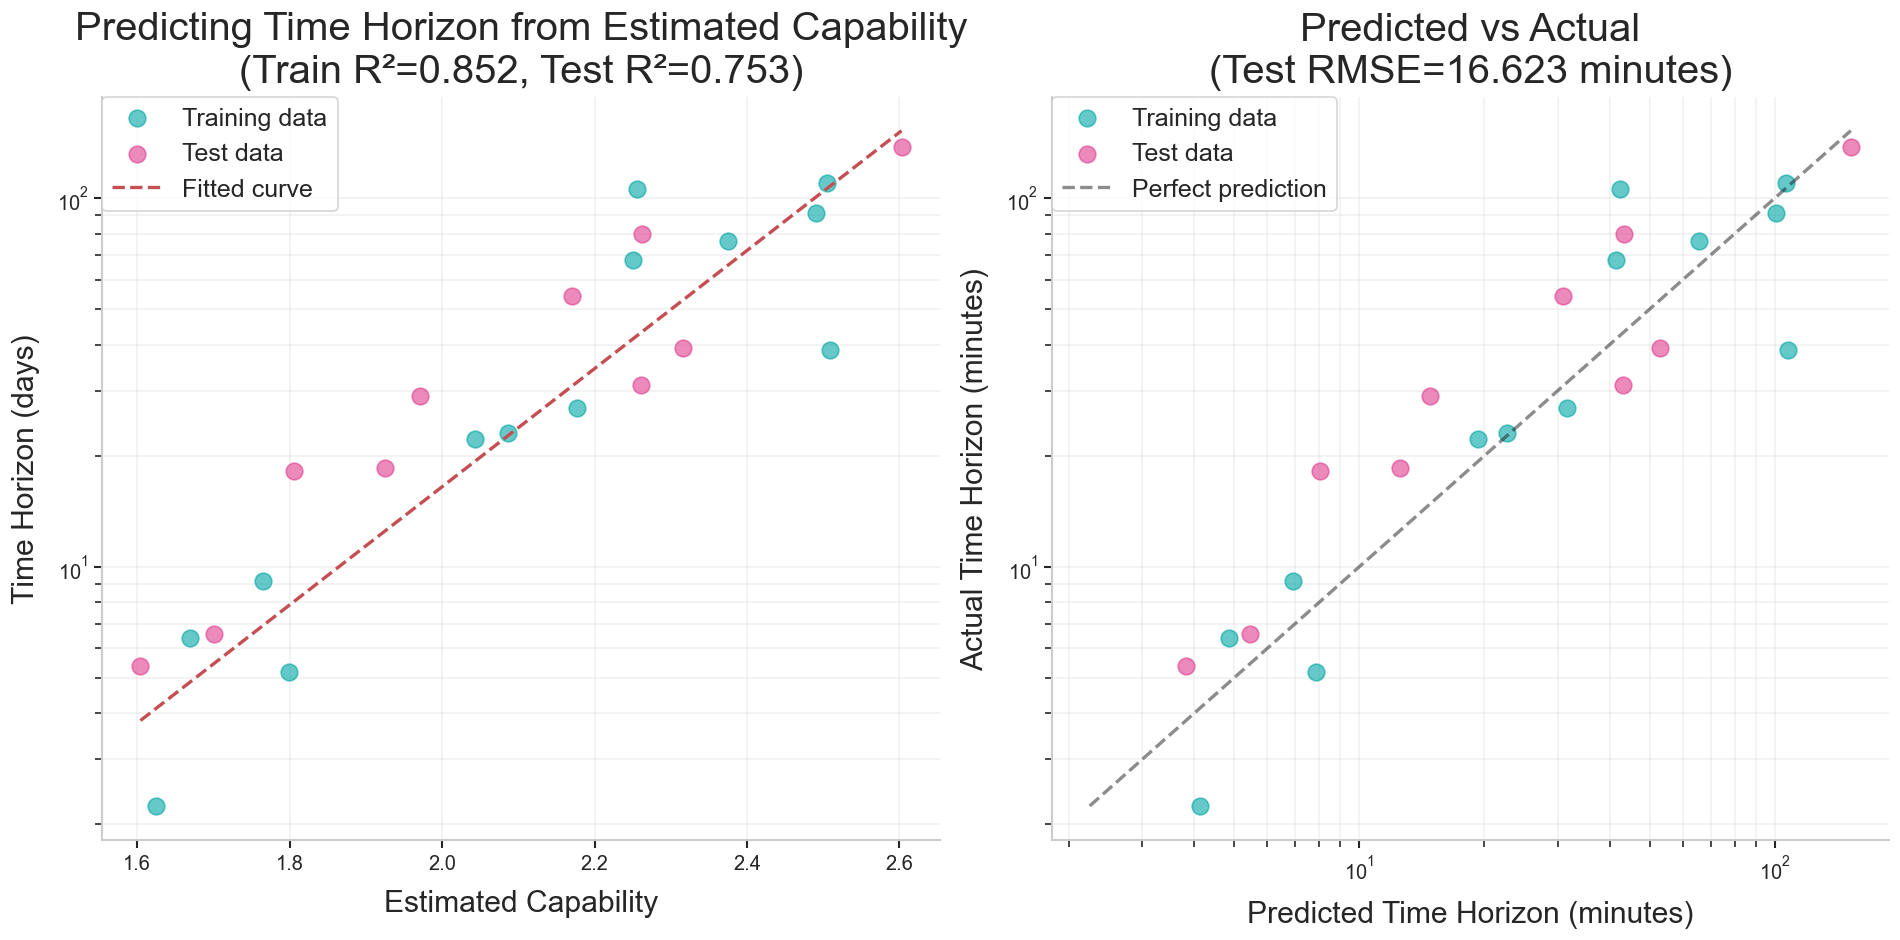


TEST SET PREDICTIONS (Original Scale)
                         model  estimated_capability  time_horizon  predicted_time_horizon      error  abs_error  pct_error
    claude-opus-4-20250514_16K              2.262734     79.862937               43.415138  36.447799  36.447799  45.637940
claude-3-7-sonnet-20250219_16K              2.170476     54.226342               30.891711  23.334631  23.334631  43.031911
       gpt-5-2025-08-07_medium              2.602780    137.318539              152.195515 -14.876976  14.876976 -10.833917
    claude-3-5-sonnet-20241022              1.970712     28.983512               14.784806  14.198706  14.198706  48.988906
          o1-2024-12-17_medium              2.315625     39.206576               52.768450 -13.561874  13.561874 -34.590815
              DeepSeek-R1-0528              2.260334     31.167847               43.032500 -11.864653  11.864653 -38.066965
    claude-3-5-sonnet-20240620              1.805797     18.216830                8.046678  1

In [11]:
# Combine df_metr and df_cm1 to predict time_horizon from estimated_capability
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import scipy.stats as stats

# Merge the two dataframes on model
df_combined = df_metr.merge(
    df_cm1[["model", "estimated_capability"]], on="model", how="inner"
)

print(f"Original df_metr rows: {len(df_metr)}")
print(f"Original df_cm1 rows: {len(df_cm1)}")
print(f"Combined df rows (models in both): {len(df_combined)}")
print(f"\nModels in combined dataset:")
print(df_combined[["model", "time_horizon", "estimated_capability"]])

# Check for missing values
print(f"\nMissing values:")
print(df_combined[["model", "time_horizon", "estimated_capability"]].isnull().sum())

# Remove any rows with missing values and non-positive time_horizon values
df_combined_clean = df_combined.dropna(subset=["time_horizon", "estimated_capability"])
df_combined_clean = df_combined_clean[df_combined_clean["time_horizon"] > 0].copy()
print(
    f"\nRows after removing missing values and non-positive time_horizon: {len(df_combined_clean)}"
)

# Add log-transformed time_horizon
df_combined_clean["log_time_horizon"] = np.log(df_combined_clean["time_horizon"])
print(f"\nTime horizon statistics:")
print(
    f"  Original - Min: {df_combined_clean['time_horizon'].min():.2f}, Max: {df_combined_clean['time_horizon'].max():.2f}, Mean: {df_combined_clean['time_horizon'].mean():.2f}"
)
print(
    f"  Log-transformed - Min: {df_combined_clean['log_time_horizon'].min():.2f}, Max: {df_combined_clean['log_time_horizon'].max():.2f}, Mean: {df_combined_clean['log_time_horizon'].mean():.2f}"
)

if len(df_combined_clean) < 5:
    print("\n⚠️ WARNING: Too few data points for meaningful train-test split analysis!")
    print("Consider using leave-one-out cross-validation or all data for fitting.")
else:
    # Train-test split (80/20)
    X = df_combined_clean[["estimated_capability"]].values
    y = df_combined_clean["log_time_horizon"].values  # Use log-transformed target
    y_original = df_combined_clean["time_horizon"].values  # Keep original for reference

    # Random state for reproducibility
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
        X, y, df_combined_clean.index, test_size=0.4, random_state=42
    )

    print(f"\nTrain set size: {len(X_train)}")
    print(f"Test set size: {len(X_test)}")

    # Fit linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Metrics on training set
    train_r2 = r2_score(y_train, y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)

    # Metrics on test set
    test_r2 = r2_score(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)

    # Pearson correlation
    train_corr, train_corr_pval = stats.pearsonr(y_train, y_train_pred)
    test_corr, test_corr_pval = stats.pearsonr(y_test, y_test_pred)

    # Calculate metrics on original scale as well
    y_train_original = y_original[idx_train]
    y_test_original = y_original[idx_test]
    y_train_pred_original = np.exp(y_train_pred)
    y_test_pred_original = np.exp(y_test_pred)

    train_r2_original = r2_score(y_train_original, y_train_pred_original)
    test_r2_original = r2_score(y_test_original, y_test_pred_original)
    train_rmse_original = np.sqrt(
        mean_squared_error(y_train_original, y_train_pred_original)
    )
    test_rmse_original = np.sqrt(
        mean_squared_error(y_test_original, y_test_pred_original)
    )

    print(f"\n" + "=" * 60)
    print("MODEL PERFORMANCE (Random Split)")
    print("=" * 60)
    print(
        f"\nModel equation: log(time_horizon) = {model.coef_[0]:.4f} * estimated_capability + {model.intercept_:.4f}"
    )
    print(
        f"Or equivalently: time_horizon = exp({model.coef_[0]:.4f} * estimated_capability + {model.intercept_:.4f})"
    )

    print(f"\nTraining Set (log scale):")
    print(f"  R²: {train_r2:.4f}")
    print(f"  RMSE: {train_rmse:.4f}")
    print(f"  MAE: {train_mae:.4f}")
    print(f"  Pearson r: {train_corr:.4f} (p={train_corr_pval:.4f})")

    print(f"\nTest Set (log scale):")
    print(f"  R²: {test_r2:.4f}")
    print(f"  RMSE: {test_rmse:.4f}")
    print(f"  MAE: {test_mae:.4f}")
    print(f"  Pearson r: {test_corr:.4f} (p={test_corr_pval:.4f})")

    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Plot 1: Scatter plot with fit line (with log scale on y-axis)
    ax1 = axes[0]
    # Plot original time_horizon values (not log-transformed)
    ax1.scatter(
        X_train,
        y_train_original,
        alpha=0.6,
        s=100,
        label="Training data",
        color=colors[0],
    )
    ax1.scatter(
        X_test, y_test_original, alpha=0.6, s=100, label="Test data", color=colors[1]
    )

    # Plot regression line (back-transformed to original scale)
    X_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    y_range_pred = model.predict(X_range)
    y_range_pred_original = np.exp(y_range_pred)
    ax1.plot(X_range, y_range_pred_original, "r--", linewidth=2, label="Fitted curve")

    ax1.set_xlabel("Estimated Capability", fontsize=18)
    ax1.set_ylabel("Time Horizon (days)", fontsize=18)
    ax1.set_yscale("log")  # Set y-axis to logarithmic scale
    ax1.set_title(
        f"Predicting Time Horizon from Estimated Capability\n(Train R²={train_r2:.3f}, Test R²={test_r2:.3f})",
        fontsize=24,
    )
    ax1.legend(fontsize=15)
    ax1.grid(True, alpha=0.3, which="both")  # Show grid for both major and minor ticks

    # Plot 2: Predicted vs Actual (with log scale on both axes)
    ax2 = axes[1]
    ax2.scatter(
        y_train_pred_original,
        y_train_original,
        alpha=0.6,
        s=100,
        label="Training data",
        color=colors[0],
    )
    ax2.scatter(
        y_test_pred_original,
        y_test_original,
        alpha=0.6,
        s=100,
        label="Test data",
        color=colors[1],
    )

    # Plot diagonal line (perfect predictions)
    y_min_orig = min(
        y_original.min(), y_train_pred_original.min(), y_test_pred_original.min()
    )
    y_max_orig = max(
        y_original.max(), y_train_pred_original.max(), y_test_pred_original.max()
    )
    ax2.plot(
        [y_min_orig, y_max_orig],
        [y_min_orig, y_max_orig],
        "k--",
        linewidth=2,
        alpha=0.5,
        label="Perfect prediction",
    )

    ax2.set_xlabel("Predicted Time Horizon (minutes)", fontsize=18)
    ax2.set_ylabel("Actual Time Horizon (minutes)", fontsize=18)
    ax2.set_xscale("log")  # Set x-axis to logarithmic scale
    ax2.set_yscale("log")  # Set y-axis to logarithmic scale
    ax2.set_title(
        f"Predicted vs Actual\n(Test RMSE={test_rmse_original:.3f} minutes)",
        fontsize=24,
    )
    ax2.legend(fontsize=15)
    ax2.grid(True, alpha=0.3, which="both")  # Show grid for both major and minor ticks

    plt.tight_layout()
    plt.savefig(
        "outputs/model_fit/predicting_time_horizon_from_capability.pdf",
        dpi=300,
        bbox_inches="tight",
    )
    plt.savefig("outputs/model_fit/predicting_time_horizon_from_capability.svg", format="svg")
    # plt.savefig("outputs/figures/figure-3.svg", format="svg")

    plt.show()

    # Print test set predictions vs actuals
    print(f"\n" + "=" * 60)
    print("TEST SET PREDICTIONS (Original Scale)")
    print("=" * 60)
    test_results = df_combined_clean.loc[
        idx_test, ["model", "estimated_capability", "time_horizon"]
    ].copy()
    test_results["predicted_time_horizon"] = y_test_pred_original
    test_results["error"] = y_test_original - y_test_pred_original
    test_results["abs_error"] = np.abs(test_results["error"])
    test_results["pct_error"] = 100 * test_results["error"] / y_test_original
    test_results = test_results.sort_values("abs_error", ascending=False)

    print(test_results.to_string(index=False))

In [12]:
# ============================================================================
# BENCHMARK-BASED ANALYSIS: Predict time_horizon from benchmark performance
# ============================================================================
# TO ANALYZE A DIFFERENT BENCHMARK: Simply change BENCHMARK_NAME below!
# ============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import scipy.stats as stats

# ============================================================================
# BENCHMARK CONFIGURATION - Change this to analyze different benchmarks!
# ============================================================================
# Examples: "GPQA diamond", "MMLU", "BBH", "HellaSwag", "MATH level 5",
#           "FrontierMath-2025-02-28-Private", "ARC AI2", etc.
# To see all available: print(sorted(df1['benchmark'].unique()))

BENCHMARK_NAME = "GPQA diamond"  # ← CHANGE THIS to analyze different benchmarks

# ============================================================================

# Filter for specified benchmark
df_benchmark = df1[df1["benchmark"] == BENCHMARK_NAME].copy()
print(f"'{BENCHMARK_NAME}' benchmark has {len(df_benchmark)} model evaluations")

if len(df_benchmark) == 0:
    print(f"\n⚠️ ERROR: No data found for benchmark '{BENCHMARK_NAME}'")
    print("\nAvailable benchmarks:")
    for bench in sorted(df1["benchmark"].unique()):
        print(f"  - {bench}")

# Apply inverse sigmoid (logit) transformation to performance
# logit(p) = log(p / (1-p))
# Clip performance to avoid log(0) or log(inf)
epsilon = 1e-6
df_benchmark["performance_clipped"] = df_benchmark["performance"].clip(
    epsilon, 1 - epsilon
)
df_benchmark["logit_performance"] = np.log(
    df_benchmark["performance_clipped"] / (1 - df_benchmark["performance_clipped"])
)

print(f"\n{BENCHMARK_NAME} Performance statistics:")
print(
    f"  Original - Min: {df_benchmark['performance'].min():.4f}, Max: {df_benchmark['performance'].max():.4f}, Mean: {df_benchmark['performance'].mean():.4f}"
)
print(
    f"  Logit-transformed - Min: {df_benchmark['logit_performance'].min():.4f}, Max: {df_benchmark['logit_performance'].max():.4f}, Mean: {df_benchmark['logit_performance'].mean():.4f}"
)

# Merge with METR time_horizon data
df_benchmark_metr = df_benchmark.merge(
    df_metr[["model", "time_horizon"]], on="model", how="inner"
)

# Also merge with model dates for temporal split
df_benchmark_metr = df_benchmark_metr.merge(
    df_cm1[["model", "date", "date_obj"]], on="model", how="inner"
)

print(
    f"\nModels with both {BENCHMARK_NAME} performance and METR time_horizon: {len(df_benchmark_metr)}"
)
print(f"\nModels in combined {BENCHMARK_NAME}-METR dataset:")
print(
    df_benchmark_metr[
        ["model", "performance", "logit_performance", "time_horizon"]
    ].to_string(index=False)
)

'GPQA diamond' benchmark has 102 model evaluations

GPQA diamond Performance statistics:
  Original - Min: 0.1470, Max: 0.8760, Mean: 0.5884
  Logit-transformed - Min: -1.7583, Max: 1.9551, Mean: 0.4075

Models with both GPQA diamond performance and METR time_horizon: 21

Models in combined GPQA diamond-METR dataset:
                         model  performance  logit_performance  time_horizon
          o1-2024-12-17_medium        0.758           1.141746     39.206576
                   DeepSeek-V3        0.565           0.261480     18.472532
                   grok-4-0709        0.870           1.900959    110.075251
       gpt-5-2025-08-07_medium        0.854           1.766325    137.318539
  claude-opus-4-1-20250805_16K        0.773           1.225329    105.499169
  gemini-2.5-pro-preview-06-05        0.848           1.719000     38.734274
              DeepSeek-R1-0528        0.763           1.169198     31.167847
                   DeepSeek-R1        0.717           0.929629   


Rows after removing missing values and non-positive time_horizon: 21

Train set size: 12
Test set size: 9

GPQA DIAMOND RANDOM SPLIT MODEL PERFORMANCE

Model equation: log(time_horizon) = 1.5609 * logit(GPQA diamond_perf) + 2.0866
Or equivalently: time_horizon = exp(1.5609 * logit(GPQA diamond_perf) + 2.0866)

Training Set (log scale):
  R²: 0.8418
  RMSE: 0.4718
  MAE: 0.3834
  Pearson r: 0.9175 (p=0.0000)

Test Set (log scale):
  R²: 0.6485
  RMSE: 0.5928
  MAE: 0.4794
  Pearson r: 0.8943 (p=0.0011)


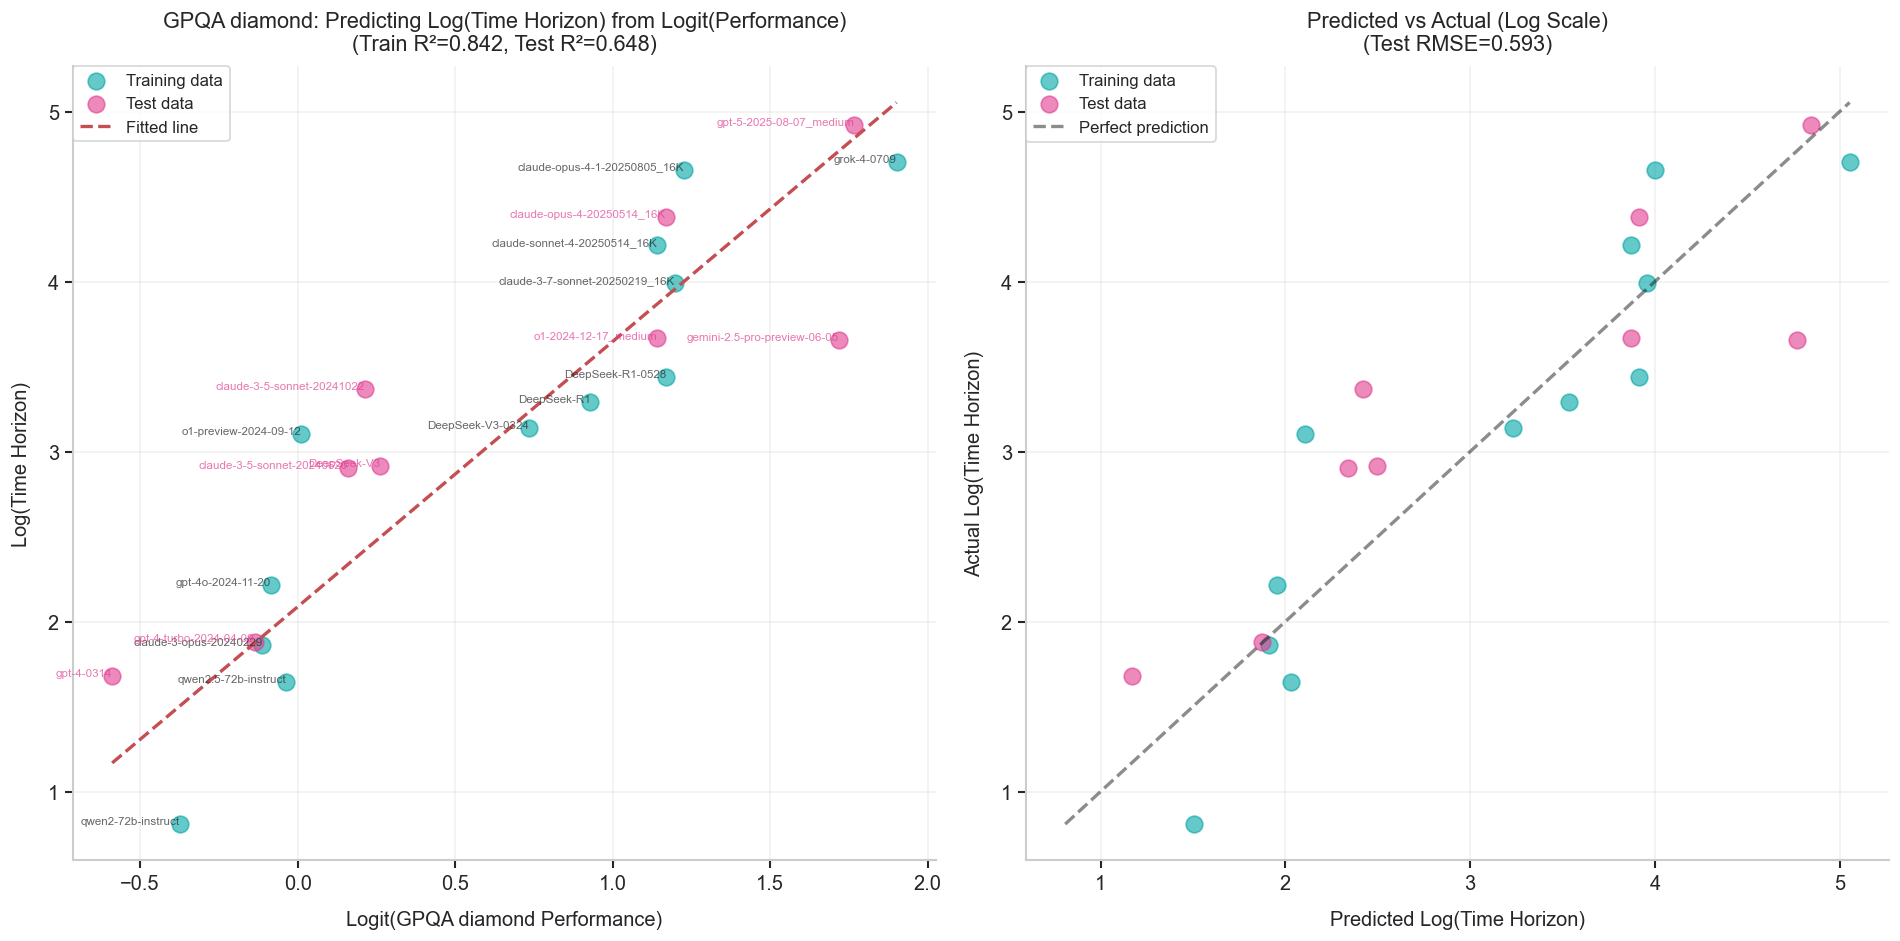


TEST SET PREDICTIONS (Original Scale)
                       model  performance  logit_performance  time_horizon  predicted_time_horizon      error  abs_error   pct_error
gemini-2.5-pro-preview-06-05        0.848           1.719000     38.734274              117.890913 -79.156639  79.156639 -204.358132
  claude-opus-4-20250514_16K        0.763           1.169198     79.862937               49.977988  29.884949  29.884949   37.420298
  claude-3-5-sonnet-20241022        0.553           0.212799     28.983512               11.231882  17.751630  17.751630   61.247339
     gpt-5-2025-08-07_medium        0.854           1.766325    137.318539              126.928975  10.389564  10.389564    7.566032
        o1-2024-12-17_medium        0.758           1.141746     39.206576               47.881679  -8.675103   8.675103  -22.126653
  claude-3-5-sonnet-20240620        0.540           0.160343     18.216830               10.348871   7.867959   7.867959   43.190602
                 DeepSeek-V3  

In [13]:
# BENCHMARK RANDOM SPLIT: Predict log(time_horizon) from logit(benchmark performance)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import scipy.stats as stats

# Remove rows with missing values and non-positive time_horizon values
df_benchmark_clean = df_benchmark_metr.dropna(
    subset=["time_horizon", "logit_performance"]
)
df_benchmark_clean = df_benchmark_clean[df_benchmark_clean["time_horizon"] > 0].copy()
print(
    f"\nRows after removing missing values and non-positive time_horizon: {len(df_benchmark_clean)}"
)

# Add log-transformed time_horizon
df_benchmark_clean["log_time_horizon"] = np.log(df_benchmark_clean["time_horizon"])

if len(df_benchmark_clean) < 5:
    print("\n⚠️ WARNING: Too few data points for meaningful train-test split analysis!")
else:
    # Train-test split (80/20)
    X = df_benchmark_clean[["logit_performance"]].values
    y = df_benchmark_clean["log_time_horizon"].values  # Use log-transformed target
    y_original = df_benchmark_clean[
        "time_horizon"
    ].values  # Keep original for reference

    # Random state for reproducibility
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
        X, y, df_benchmark_clean.index, test_size=0.4, random_state=42
    )

    print(f"\nTrain set size: {len(X_train)}")
    print(f"Test set size: {len(X_test)}")

    # Fit linear regression model
    model_gpqa = LinearRegression()
    model_gpqa.fit(X_train, y_train)

    # Predictions
    y_train_pred = model_gpqa.predict(X_train)
    y_test_pred = model_gpqa.predict(X_test)

    # Metrics on log scale
    train_r2 = r2_score(y_train, y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)

    test_r2 = r2_score(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)

    # Pearson correlation
    train_corr, train_corr_pval = stats.pearsonr(y_train, y_train_pred)
    test_corr, test_corr_pval = stats.pearsonr(y_test, y_test_pred)

    # Calculate metrics on original scale as well
    y_train_original = y_original[idx_train]
    y_test_original = y_original[idx_test]
    y_train_pred_original = np.exp(y_train_pred)
    y_test_pred_original = np.exp(y_test_pred)

    train_r2_original = r2_score(y_train_original, y_train_pred_original)
    test_r2_original = r2_score(y_test_original, y_test_pred_original)
    train_rmse_original = np.sqrt(
        mean_squared_error(y_train_original, y_train_pred_original)
    )
    test_rmse_original = np.sqrt(
        mean_squared_error(y_test_original, y_test_pred_original)
    )

    print(f"\n" + "=" * 60)
    print(f"{BENCHMARK_NAME.upper()} RANDOM SPLIT MODEL PERFORMANCE")
    print("=" * 60)
    print(
        f"\nModel equation: log(time_horizon) = {model_gpqa.coef_[0]:.4f} * logit({BENCHMARK_NAME}_perf) + {model_gpqa.intercept_:.4f}"
    )
    print(
        f"Or equivalently: time_horizon = exp({model_gpqa.coef_[0]:.4f} * logit({BENCHMARK_NAME}_perf) + {model_gpqa.intercept_:.4f})"
    )

    print(f"\nTraining Set (log scale):")
    print(f"  R²: {train_r2:.4f}")
    print(f"  RMSE: {train_rmse:.4f}")
    print(f"  MAE: {train_mae:.4f}")
    print(f"  Pearson r: {train_corr:.4f} (p={train_corr_pval:.4f})")

    print(f"\nTest Set (log scale):")
    print(f"  R²: {test_r2:.4f}")
    print(f"  RMSE: {test_rmse:.4f}")
    print(f"  MAE: {test_mae:.4f}")
    print(f"  Pearson r: {test_corr:.4f} (p={test_corr_pval:.4f})")

    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Plot 1: Scatter plot with fit line (LOG SCALE)
    ax1 = axes[0]
    ax1.scatter(
        X_train, y_train, alpha=0.6, s=100, label="Training data", color=colors[0]
    )
    ax1.scatter(X_test, y_test, alpha=0.6, s=100, label="Test data", color=colors[1])

    # Plot regression line
    X_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    y_range_pred = model_gpqa.predict(X_range)
    ax1.plot(X_range, y_range_pred, "r--", linewidth=2, label="Fitted line")

    # Annotate points with model names
    for idx in idx_train:
        ax1.annotate(
            df_benchmark_clean.loc[idx, "model"],
            xy=(
                df_benchmark_clean.loc[idx, "logit_performance"],
                df_benchmark_clean.loc[idx, "log_time_horizon"],
            ),
            fontsize=7,
            alpha=0.7,
            ha="right",
        )

    for idx in idx_test:
        ax1.annotate(
            df_benchmark_clean.loc[idx, "model"],
            xy=(
                df_benchmark_clean.loc[idx, "logit_performance"],
                df_benchmark_clean.loc[idx, "log_time_horizon"],
            ),
            fontsize=7,
            alpha=0.7,
            ha="right",
            color=colors[1],
        )

    ax1.set_xlabel(f"Logit({BENCHMARK_NAME} Performance)", fontsize=12)
    ax1.set_ylabel("Log(Time Horizon)", fontsize=12)
    ax1.set_title(
        f"{BENCHMARK_NAME}: Predicting Log(Time Horizon) from Logit(Performance)\n(Train R²={train_r2:.3f}, Test R²={test_r2:.3f})",
        fontsize=13,
    )
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Predicted vs Actual (LOG SCALE)
    ax2 = axes[1]
    ax2.scatter(
        y_train_pred, y_train, alpha=0.6, s=100, label="Training data", color=colors[0]
    )
    ax2.scatter(
        y_test_pred, y_test, alpha=0.6, s=100, label="Test data", color=colors[1]
    )

    # Plot diagonal line (perfect predictions)
    y_min = min(y.min(), y_train_pred.min(), y_test_pred.min())
    y_max = max(y.max(), y_train_pred.max(), y_test_pred.max())
    ax2.plot(
        [y_min, y_max],
        [y_min, y_max],
        "k--",
        linewidth=2,
        alpha=0.5,
        label="Perfect prediction",
    )

    ax2.set_xlabel("Predicted Log(Time Horizon)", fontsize=12)
    ax2.set_ylabel("Actual Log(Time Horizon)", fontsize=12)
    ax2.set_title(
        f"Predicted vs Actual (Log Scale)\n(Test RMSE={test_rmse:.3f})", fontsize=13
    )
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(
        "outputs/notebooks/predicting_time_horizon_from_benchmark_performance.pdf",
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()

    # Print test set predictions vs actuals
    print(f"\n" + "=" * 60)
    print("TEST SET PREDICTIONS (Original Scale)")
    print("=" * 60)
    test_results = df_benchmark_clean.loc[
        idx_test, ["model", "performance", "logit_performance", "time_horizon"]
    ].copy()
    test_results["predicted_time_horizon"] = y_test_pred_original
    test_results["error"] = y_test_original - y_test_pred_original
    test_results["abs_error"] = np.abs(test_results["error"])
    test_results["pct_error"] = 100 * test_results["error"] / y_test_original
    test_results = test_results.sort_values("abs_error", ascending=False)

    print(test_results.to_string(index=False))

In [14]:
# ============================================================================
# Global benchmark sweep: fit log(time_horizon) ~ logit(performance)
# across every benchmark with enough METR overlap.
# ============================================================================

min_points_required = 5
benchmark_results = []
benchmarks_missing_data = []
all_benchmarks = sorted(df1["benchmark"].dropna().unique())

for benchmark_name in all_benchmarks:
    df_benchmark = df1[df1["benchmark"] == benchmark_name].copy()
    if df_benchmark.empty or "performance" not in df_benchmark:
        continue

    epsilon = 1e-6
    df_benchmark["performance_clipped"] = df_benchmark["performance"].clip(
        epsilon, 1 - epsilon
    )
    df_benchmark["logit_performance"] = np.log(
        df_benchmark["performance_clipped"]
        / (1 - df_benchmark["performance_clipped"])
    )

    df_benchmark_metr = (
        df_benchmark.merge(df_metr[["model", "time_horizon"]], on="model", how="inner")
        .merge(df_cm1[["model", "date", "date_obj"]], on="model", how="inner")
    )

    df_benchmark_clean = df_benchmark_metr.dropna(
        subset=["time_horizon", "logit_performance"]
    )
    df_benchmark_clean = df_benchmark_clean[df_benchmark_clean["time_horizon"] > 0].copy()
    df_benchmark_clean.reset_index(drop=True, inplace=True)

    if len(df_benchmark_clean) < min_points_required:
        benchmarks_missing_data.append((benchmark_name, len(df_benchmark_clean)))
        continue

    X = df_benchmark_clean[["logit_performance"]].to_numpy()
    y = np.log(df_benchmark_clean["time_horizon"].to_numpy())
    indices = df_benchmark_clean.index.to_numpy()

    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
        X,
        y,
        indices,
        test_size=0.4,
        random_state=42,
    )

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_corr, _ = stats.pearsonr(y_train, y_train_pred)
    test_corr, _ = stats.pearsonr(y_test, y_test_pred)

    y_train_original = df_benchmark_clean.loc[idx_train, "time_horizon"].to_numpy()
    y_test_original = df_benchmark_clean.loc[idx_test, "time_horizon"].to_numpy()
    y_train_pred_original = np.exp(y_train_pred)
    y_test_pred_original = np.exp(y_test_pred)

    train_r2_original = r2_score(y_train_original, y_train_pred_original)
    test_r2_original = r2_score(y_test_original, y_test_pred_original)
    train_rmse_original = np.sqrt(
        mean_squared_error(y_train_original, y_train_pred_original)
    )
    test_rmse_original = np.sqrt(
        mean_squared_error(y_test_original, y_test_pred_original)
    )

    benchmark_results.append(
        {
            "benchmark": benchmark_name,
            # "n_all_scores": len(df_benchmark),
            # "n_joined_metr": len(df_benchmark_metr),
            "n_clean": len(df_benchmark_clean),
            # "coef": float(model.coef_[0]),
            "intercept": float(model.intercept_),
            "train_r2": train_r2,
            "test_r2": test_r2,
            # "train_rmse": train_rmse,
            # "test_rmse": test_rmse,
            # "train_mae": train_mae,
            # "test_mae": test_mae,
            # "train_corr": train_corr,
            # "test_corr": test_corr,
            # "train_r2_original": train_r2_original,
            # "test_r2_original": test_r2_original,
            # "train_rmse_original": train_rmse_original,
            # "test_rmse_original": test_rmse_original,
        }
    )

benchmark_results_df = pd.DataFrame(benchmark_results)

if benchmark_results_df.empty:
    print("No benchmarks had enough overlapping METR time_horizon data to fit the model.")
else:
    benchmark_results_df.sort_values("test_r2", ascending=False, inplace=True)
    display(benchmark_results_df.head(20))

    summary_cols = [
        "test_r2",
        # "test_rmse",
        # "test_mae",
        # "test_r2_original",
        # "test_rmse_original",
    ]
    summary_table = benchmark_results_df[summary_cols].agg(["mean", "median", "min", "max"])

    print("\nGlobal summary across benchmarks:")
    print(summary_table)
    weighted_r2 = (
        benchmark_results_df["test_r2"] * benchmark_results_df["n_clean"]
    ).sum() / benchmark_results_df["n_clean"].sum()
    print(f"\nWeighted average test R² (by clean sample count): {weighted_r2:.3f}")
    print(
        f"Benchmarks analyzed: {len(benchmark_results_df)} / {len(all_benchmarks)}"
    )

if benchmarks_missing_data:
    print("\nBenchmarks skipped due to insufficient data (rows after cleaning):")
    for name, count in benchmarks_missing_data:
        print(f"  • {name}: {count} usable rows")


,benchmark,n_clean,intercept,train_r2,test_r2
15,Terminal Bench,5,4.893138,0.976617,0.985559
0,ARC-AGI,11,4.608832,0.885968,0.912674
1,Aider polyglot,10,3.101133,0.775520,0.826652
5,FrontierMath-Tier-4-2025-07-01-Private,6,4.636164,0.507953,0.803129
17,WeirdML,13,4.328327,0.605873,0.775492
4,FrontierMath-2025-02-28-Private,10,5.358809,0.968852,0.759104
16,VPCT,10,4.126110,0.202875,0.691484
12,OTIS Mock AIME 2024-2025,19,3.711692,0.801419,0.668834
6,GPQA diamond,21,2.086601,0.841793,0.648452
10,MATH level 5,15,2.242840,0.645896,0.582244



Global summary across benchmarks:
         test_r2
mean   -0.219251
median  0.615348
min    -4.992608
max     0.985559

Weighted average test R² (by clean sample count): 0.105
Benchmarks analyzed: 18 / 38

Benchmarks skipped due to insufficient data (rows after cleaning):
  • ANLI: 0 usable rows
  • ARC AI2: 1 usable rows
  • BBH: 1 usable rows
  • Balrog: 4 usable rows
  • CadEval: 4 usable rows
  • Cybench: 4 usable rows
  • Factorio learning environment: 3 usable rows
  • GSM8K: 1 usable rows
  • GSO-Bench: 2 usable rows
  • HellaSwag: 2 usable rows
  • LAMBADA: 0 usable rows
  • OSUniverse: 2 usable rows
  • OSWorld: 4 usable rows
  • OpenBookQA: 0 usable rows
  • PIQA: 0 usable rows
  • ScienceQA: 0 usable rows
  • The Agent Company: 4 usable rows
  • TriviaQA: 1 usable rows
  • VideoMME: 1 usable rows
  • Winogrande: 3 usable rows


# Figure 4: SWE-bench and GeoBench residuals (Section 3.1.2 Are models optimized for different objectives?)

Figure saved to: outputs/model_fit/benchmark_comparison_swe_geo.svg


/var/folders/dn/nknbl4x9401_pvgxvxc0663w0000gn/T/ipykernel_44342/1311456259.py:93: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(


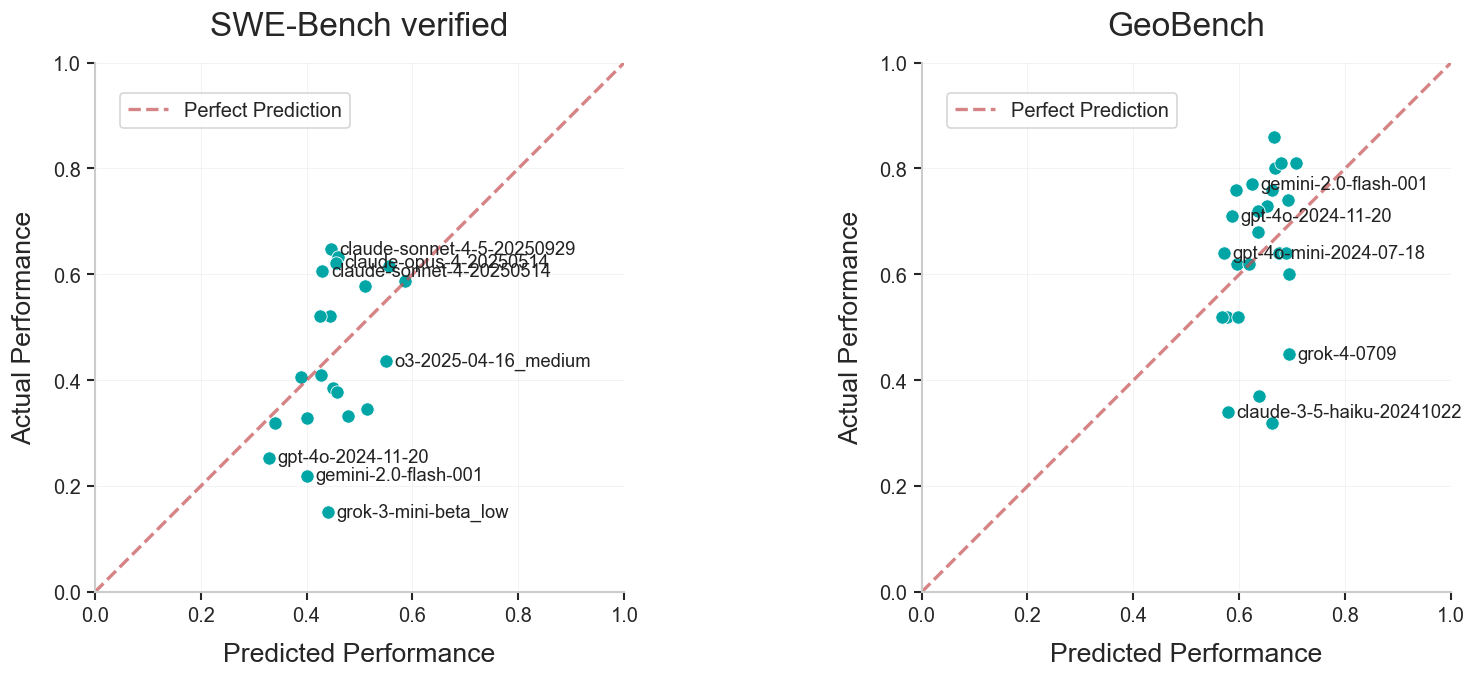


Summary Statistics:

SWE-Bench verified:
  Number of models: 22
  RMSE: 0.1322
  MAE: 0.1109

GeoBench:
  Number of models: 25
  RMSE: 0.1426
  MAE: 0.1160


In [15]:
def plot_two_benchmarks_comparison(
    benchmark1_name,
    benchmark2_name,
    df_data=df1,
    df_capabilities=df_cm1,
    df_benchmarks=df_db1,
    models_to_annotate=None,
    annotate_all=False,
    figsize=(14, 6),
    save_path=None,
    annotation_color=None,
):
    """
    Create a side-by-side comparison of two benchmarks with model annotations.

    Parameters:
    -----------
    benchmark1_name : str
        Name of the first benchmark to plot
    benchmark2_name : str
        Name of the second benchmark to plot
    df_data : DataFrame
        DataFrame containing performance data (default: df1)
    df_capabilities : DataFrame
        DataFrame containing model capabilities (default: df_cm1)
    df_benchmarks : DataFrame
        DataFrame containing benchmark parameters (default: df_db1)
    models_to_annotate : list, optional
        List of model names to annotate. If None and annotate_all is False, no annotations.
    annotate_all : bool, default False
        If True, annotate all models (overrides models_to_annotate)
    figsize : tuple, default (14, 6)
        Figure size as (width, height)
    save_path : str, optional
        If provided, save the figure to this path
    annotation_color : str, optional
        Override the annotation text color to keep it visible with custom styles
    """

    import matplotlib.colors as mcolors

    def logistic(x):
        return 1.0 / (1.0 + np.exp(-x))

    def _resolve_annotation_color(ax):
        if annotation_color is not None:
            return annotation_color
        face_rgb = np.array(mcolors.to_rgb(ax.get_facecolor()))
        luminance = 0.299 * face_rgb[0] + 0.587 * face_rgb[1] + 0.114 * face_rgb[2]
        return "#f5f5f5" if luminance < 0.5 else "#222222"

    def prepare_benchmark_data(benchmark_name):
        """Helper function to prepare data for one benchmark"""
        # Get data for this benchmark
        bench_data = df_data[df_data["benchmark"] == benchmark_name].copy()

        if len(bench_data) == 0:
            raise ValueError(f"No data found for benchmark: {benchmark_name}")

        # Get benchmark parameters
        bench_params_df = df_benchmarks[
            df_benchmarks["benchmark_name"] == benchmark_name
        ]
        if len(bench_params_df) == 0:
            raise ValueError(f"No parameters found for benchmark: {benchmark_name}")

        bench_params = bench_params_df.iloc[0]
        D = bench_params["estimated_difficulty"]
        alpha = bench_params["estimated_slope"]

        # Merge with model capabilities
        bench_data = bench_data.merge(
            df_capabilities[["model", "estimated_capability"]], on="model", how="left"
        )

        # Calculate predicted performance
        bench_data["predicted"] = logistic(
            alpha * (bench_data["estimated_capability"] - D)
        )

        return bench_data, D, alpha

    # Prepare data for both benchmarks
    data1, D1, alpha1 = prepare_benchmark_data(benchmark1_name)
    data2, D2, alpha2 = prepare_benchmark_data(benchmark2_name)

    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    def plot_single_benchmark(ax, bench_data, benchmark_name, D, alpha):
        """Helper function to plot a single benchmark"""
        # Plot scatter points
        ax.scatter(
            bench_data["predicted"],
            bench_data["performance"],
            alpha=1,
            s=64,
            c=colors[0],
            edgecolors="white",
            linewidths=0.5,
        )

        # Plot diagonal line (perfect prediction)
        ax.plot(
            [0, 1], [0, 1], "r--", linewidth=2, label="Perfect Prediction", alpha=0.7
        )

        # Ensure consistent axis limits before clipping annotations
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)

        # Add annotations
        if annotate_all:
            models_to_label = bench_data["model"].tolist()
        elif models_to_annotate is not None:
            models_to_label = [
                m for m in models_to_annotate if m in bench_data["model"].values
            ]
        else:
            models_to_label = []
        annotations = []
        text_color = _resolve_annotation_color(ax)
        for model in models_to_label:
            model_data = bench_data[bench_data["model"] == model]
            if len(model_data) > 0:
                x = model_data["predicted"].iloc[0]
                y = model_data["performance"].iloc[0]
                annotations.append(
                    ax.annotate(
                        model,
                        xy=(x, y),
                        xytext=(5, 0),
                        textcoords="offset points",
                        fontsize=11,
                        #    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3),
                        ha="left",
                        va="center",
                        color=text_color,
                    )
                )

        # hide if they are out of bounds
        if annotations:
            renderer = ax.figure.canvas.get_renderer()
            if renderer is None:
                ax.figure.canvas.draw()
                renderer = ax.figure.canvas.get_renderer()
            x_min, x_max = ax.get_xlim()

            for annotation in annotations:
                # Get bounding box in display coordinates
                bbox = annotation.get_window_extent(renderer=renderer)

                # Convert bbox corners to data coordinates
                (x1, _), (x2, _) = ax.transData.inverted().transform(bbox.get_points())

                # Hide annotation if bbox extends outside the axis x-limits
                if x1 < x_min or x2 > x_max:
                    annotation.set_visible(False)

        # Calculate and display statistics
        residuals = bench_data["performance"] - bench_data["predicted"]
        rmse = np.sqrt(np.mean(residuals**2))
        mae = np.mean(np.abs(residuals))

        # Set labels and title
        ax.set_xlabel("Predicted Performance", fontsize=16)
        ax.set_ylabel("Actual Performance", fontsize=16)
        ax.set_title(
            f"{benchmark_name}",
            # f"{benchmark_name}\nDifficulty: {D:.3f}, Slope: {alpha:.3f}\n",
            # + f"RMSE: {rmse:.4f}, MAE: {mae:.4f}",
            fontsize=20,
            pad=10,
        )

        # Add grid
        ax.grid(True, alpha=0.3, linestyle="-", linewidth=0.5)
        ax.set_axisbelow(True)

        # Add legend with padding so it's not exactly at the top left
        ax.legend(
            loc="upper left",
            fontsize=12,
            bbox_to_anchor=(
                0.01,
                0.98,
            ),  # Slightly down and to the right from the top left
            borderaxespad=1.0,  # Add axes padding
            frameon=True,  # Optional: frame for clarity
        )

        # Equal aspect ratio
        ax.set_aspect("equal")

        return rmse, mae

    # Plot both benchmarks
    rmse1, mae1 = plot_single_benchmark(ax1, data1, benchmark1_name, D1, alpha1)
    rmse2, mae2 = plot_single_benchmark(ax2, data2, benchmark2_name, D2, alpha2)

    # Overall title
    fig.suptitle("", fontsize=14, fontweight="bold", y=1.00)

    plt.tight_layout()

    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"Figure saved to: {save_path}")
    # plt.savefig("outputs/figures/figure-4.svg", format="svg")
    plt.show()

    # Print summary statistics
    print(f"\nSummary Statistics:")
    print(f"\n{benchmark1_name}:")
    print(f"  Number of models: {len(data1)}")
    print(f"  RMSE: {rmse1:.4f}")
    print(f"  MAE: {mae1:.4f}")
    print(f"\n{benchmark2_name}:")
    print(f"  Number of models: {len(data2)}")
    print(f"  RMSE: {rmse2:.4f}")
    print(f"  MAE: {mae2:.4f}")


# Example usage:
# Plot two benchmarks with specific model annotations
models_to_label = [
    "gpt-4o-2024-11-20",
    "gemini-2.0-flash-001",
    "grok-3-mini-beta_low",
    "claude-sonnet-4-5-20250929",
    "claude-sonnet-4-20250514",
    "claude-opus-4-20250514",
    "o3-2025-04-16_medium",
    "grok-4-0709",
    "gpt-4o-mini-2024-07-18",
    "claude-3-5-haiku-20241022",
    # "gpt-4.1-2025-04-14",
]
plot_two_benchmarks_comparison(
    "SWE-Bench verified",
    "GeoBench",
    models_to_annotate=models_to_label,
    # annotate_all=True,
    save_path="outputs/model_fit/benchmark_comparison_swe_geo.svg",
)

# Uncomment to annotate all models (warning: can be crowded!)
# plot_two_benchmarks_comparison(
#     'SWE-Bench verified',
#     'GeoBench',
#     annotate_all=True
# )

# Figure 13: Checking residuals (Appendix D.1: Noise structure)

Line of best fit slope: 0.7159 capability units/year
R-squared: 0.7739


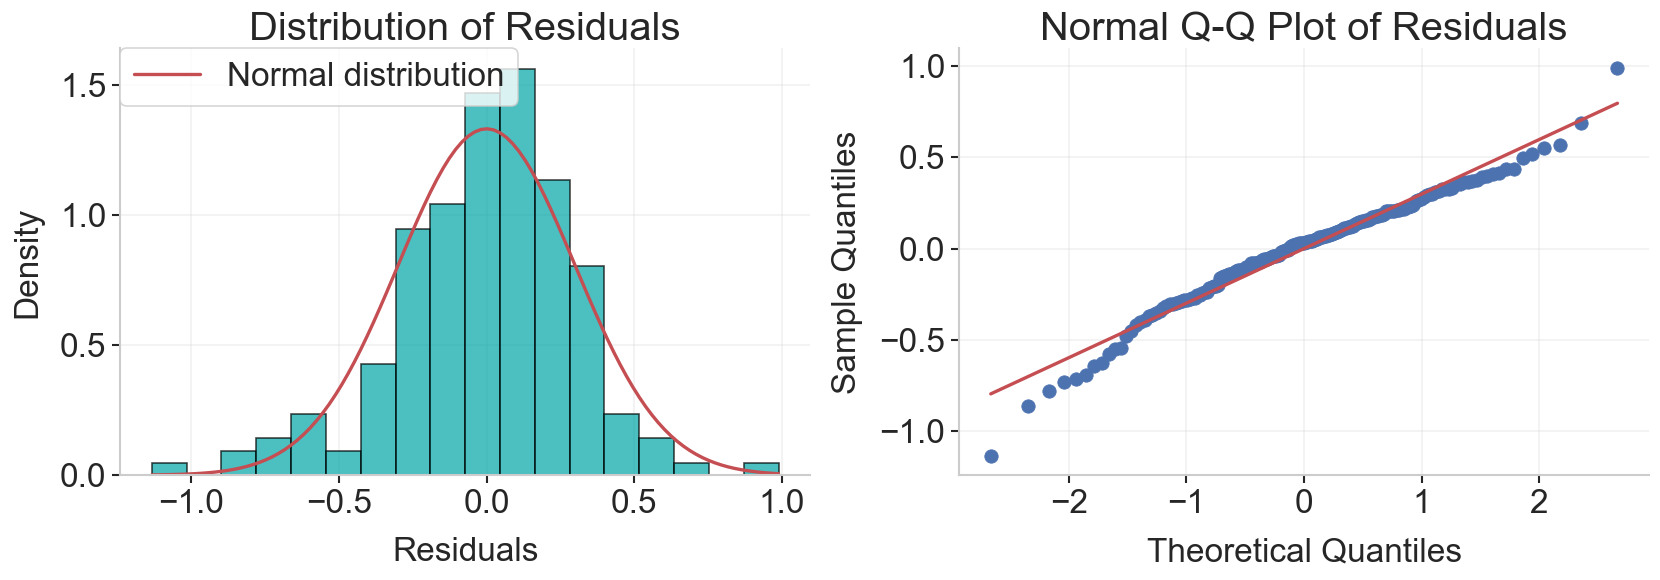


NORMALITY TESTS FOR RESIDUALS

Basic Statistics:
  Mean: -0.000000
  Standard Deviation: 0.3003
  Skewness: -0.5253
  Kurtosis: 1.3583
  Min: -1.1340
  Max: 0.9890
  Sample size: 179

Kolmogorov-Smirnov Test:
  Test statistic: 0.0689
  P-value: 0.3482
  Interpretation: FAIL TO REJECT null hypothesis of normality (α=0.05)

Shapiro-Wilk Test:
  Test statistic: 0.9743
  P-value: 0.0021
  Interpretation: REJECT null hypothesis of normality (α=0.05)

Anderson-Darling Test:
  Test statistic: 1.2522
  Critical values: [0.564 0.642 0.77  0.899 1.069]
  Significance levels: [15.  10.   5.   2.5  1. ]%
  Interpretation: REJECT null hypothesis of normality (α=0.05)

Jarque-Bera Test:
  Test statistic: 21.9925
  P-value: 0.0000
  Interpretation: REJECT null hypothesis of normality (α=0.05)

SUMMARY FOR SYNTHETIC DATA GENERATION

Normality test summary: 3/4 tests reject normality
Recommendation: ✗ GAUSSIAN NOISE assumption is NOT SUPPORTED - consider alternative noise distributions

Additional con

In [20]:
# Residuals analysis with normality testing for synthetic data generation
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import stats
import scipy.stats as stats

# Prepare data for residuals analysis
cap_df = df_cm1.copy()
cap_df["date_obj"] = pd.to_datetime(cap_df["date_obj"])
cap_df = (
    cap_df.dropna(subset=["date_obj", "estimated_capability"])
    .sort_values("date_obj")
    .reset_index(drop=True)
)

# Convert dates to numerical format for regression
X = (cap_df["date_obj"] - cap_df["date_obj"].min()).dt.days.values.reshape(-1, 1)
y = cap_df["estimated_capability"].values

# Fit linear regression (line of best fit)
lr = LinearRegression()
lr.fit(X, y)

# Calculate predicted values and residuals
y_pred = lr.predict(X)
residuals = y - y_pred

# Convert slope to per-year rate
slope_per_year = lr.coef_[0] * 365.25
r2 = lr.score(X, y)

print(f"Line of best fit slope: {slope_per_year:.4f} capability units/year")
print(f"R-squared: {r2:.4f}")

# Create residuals analysis plot (distribution and Q-Q plot only)
fig = plt.figure(figsize=(14, 5))

# 1. Histogram of residuals with normal overlay
ax1 = plt.subplot(1, 2, 1)
n_bins = int(np.sqrt(len(residuals))) + 5  # Sturges' rule with buffer
counts, bins, patches = ax1.hist(
    residuals, bins=n_bins, density=True, alpha=0.7, edgecolor="black"
)

# Overlay normal distribution
x_norm = np.linspace(residuals.min(), residuals.max(), 100)
normal_overlay = stats.norm.pdf(x_norm, np.mean(residuals), np.std(residuals))
ax1.plot(x_norm, normal_overlay, "r-", linewidth=2, label="Normal distribution")
ax1.set_xlabel("Residuals", fontsize=20)
ax1.set_ylabel("Density", fontsize=20)
ax1.set_title("Distribution of Residuals", fontsize=24)
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=20)
ax1.tick_params(labelsize=20)

# 2. Q-Q plot
ax2 = plt.subplot(1, 2, 2)
stats.probplot(residuals, dist="norm", plot=ax2)

# set line color

ax2.set_xlabel("Theoretical Quantiles", fontsize=20)
ax2.set_ylabel("Sample Quantiles", fontsize=20)
ax2.set_title("Normal Q-Q Plot of Residuals", fontsize=24)
ax2.grid(True, alpha=0.3)
ax2.tick_params(labelsize=20)

plt.tight_layout()
plt.savefig(
    "outputs/model_fit/model_capabilities_residuals_normality_analysis.pdf",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

# Statistical tests for normality
print(f"\n" + "=" * 60)
print("NORMALITY TESTS FOR RESIDUALS")
print("=" * 60)

# Basic statistics
print(f"\nBasic Statistics:")
print(f"  Mean: {np.mean(residuals):.6f}")
print(f"  Standard Deviation: {np.std(residuals, ddof=1):.4f}")
print(f"  Skewness: {stats.skew(residuals):.4f}")
print(f"  Kurtosis: {stats.kurtosis(residuals):.4f}")
print(f"  Min: {np.min(residuals):.4f}")
print(f"  Max: {np.max(residuals):.4f}")
print(f"  Sample size: {len(residuals)}")

# Kolmogorov-Smirnov test
ks_stat, ks_pvalue = stats.kstest(
    residuals, "norm", args=(np.mean(residuals), np.std(residuals))
)
print(f"\nKolmogorov-Smirnov Test:")
print(f"  Test statistic: {ks_stat:.4f}")
print(f"  P-value: {ks_pvalue:.4f}")
print(
    f"  Interpretation: {'REJECT' if ks_pvalue < 0.05 else 'FAIL TO REJECT'} null hypothesis of normality (α=0.05)"
)

# Shapiro-Wilk test (more powerful for small to moderate sample sizes)
if len(residuals) <= 5000:  # Shapiro-Wilk works best for n <= 5000
    sw_stat, sw_pvalue = stats.shapiro(residuals)
    print(f"\nShapiro-Wilk Test:")
    print(f"  Test statistic: {sw_stat:.4f}")
    print(f"  P-value: {sw_pvalue:.4f}")
    print(
        f"  Interpretation: {'REJECT' if sw_pvalue < 0.05 else 'FAIL TO REJECT'} null hypothesis of normality (α=0.05)"
    )

# Anderson-Darling test
ad_stat, ad_critical_vals, ad_significance_levels = stats.anderson(
    residuals, dist="norm"
)
print(f"\nAnderson-Darling Test:")
print(f"  Test statistic: {ad_stat:.4f}")
print(f"  Critical values: {ad_critical_vals}")
print(f"  Significance levels: {ad_significance_levels}%")
# Find the appropriate critical value for 5% significance
ad_5pct_critical = (
    ad_critical_vals[np.where(ad_significance_levels == 5)[0][0]]
    if 5 in ad_significance_levels
    else ad_critical_vals[2]
)
print(
    f"  Interpretation: {'REJECT' if ad_stat > ad_5pct_critical else 'FAIL TO REJECT'} null hypothesis of normality (α=0.05)"
)

# Jarque-Bera test
jb_stat, jb_pvalue = stats.jarque_bera(residuals)
print(f"\nJarque-Bera Test:")
print(f"  Test statistic: {jb_stat:.4f}")
print(f"  P-value: {jb_pvalue:.4f}")
print(
    f"  Interpretation: {'REJECT' if jb_pvalue < 0.05 else 'FAIL TO REJECT'} null hypothesis of normality (α=0.05)"
)

print(f"\n" + "=" * 60)
print("SUMMARY FOR SYNTHETIC DATA GENERATION")
print("=" * 60)

# Count how many tests reject normality
tests_results = [
    ("Kolmogorov-Smirnov", ks_pvalue < 0.05),
    ("Jarque-Bera", jb_pvalue < 0.05),
    ("Anderson-Darling", ad_stat > ad_5pct_critical),
]

if len(residuals) <= 5000:
    tests_results.append(("Shapiro-Wilk", sw_pvalue < 0.05))

rejections = sum([result[1] for result in tests_results])
total_tests = len(tests_results)

print(f"\nNormality test summary: {rejections}/{total_tests} tests reject normality")
if rejections == 0:
    recommendation = "✓ GAUSSIAN NOISE assumption appears REASONABLE for synthetic data"
elif rejections <= total_tests // 2:
    recommendation = "⚠ GAUSSIAN NOISE assumption is QUESTIONABLE - consider checking sample size or alternative distributions"
else:
    recommendation = "✗ GAUSSIAN NOISE assumption is NOT SUPPORTED - consider alternative noise distributions"

print(f"Recommendation: {recommendation}")

# Additional diagnostics
print(f"\nAdditional considerations:")
if abs(stats.skew(residuals)) > 0.5:
    print(f"  • Residuals show notable skewness ({stats.skew(residuals):.3f})")
if abs(stats.kurtosis(residuals)) > 1.0:
    print(f"  • Residuals show notable kurtosis ({stats.kurtosis(residuals):.3f})")
if len(residuals) < 30:
    print(
        f"  • Small sample size (n={len(residuals)}) - normality tests have limited power"
    )

print(f"\nFor synthetic data generation:")
print(f"  • Estimated noise std: {np.std(residuals, ddof=1):.4f}")
print(
    f"  • Suggested distribution: {'Normal(0, {:.4f})'.format(np.std(residuals, ddof=1)) if rejections == 0 else 'Consider empirical distribution or robust alternatives'}"
)

# Show models with extreme residuals
print(f"\nModels with largest absolute residuals (potential outliers):")
abs_residuals_idx = np.argsort(np.abs(residuals))[-5:]
for idx in abs_residuals_idx[::-1]:
    model_name = cap_df.iloc[idx]["model"]
    residual_val = residuals[idx]
    print(f"  {model_name}: {residual_val:.4f}")

# Figure 19: Model residuals on individual benchmarks (Appendix F: Model fit)

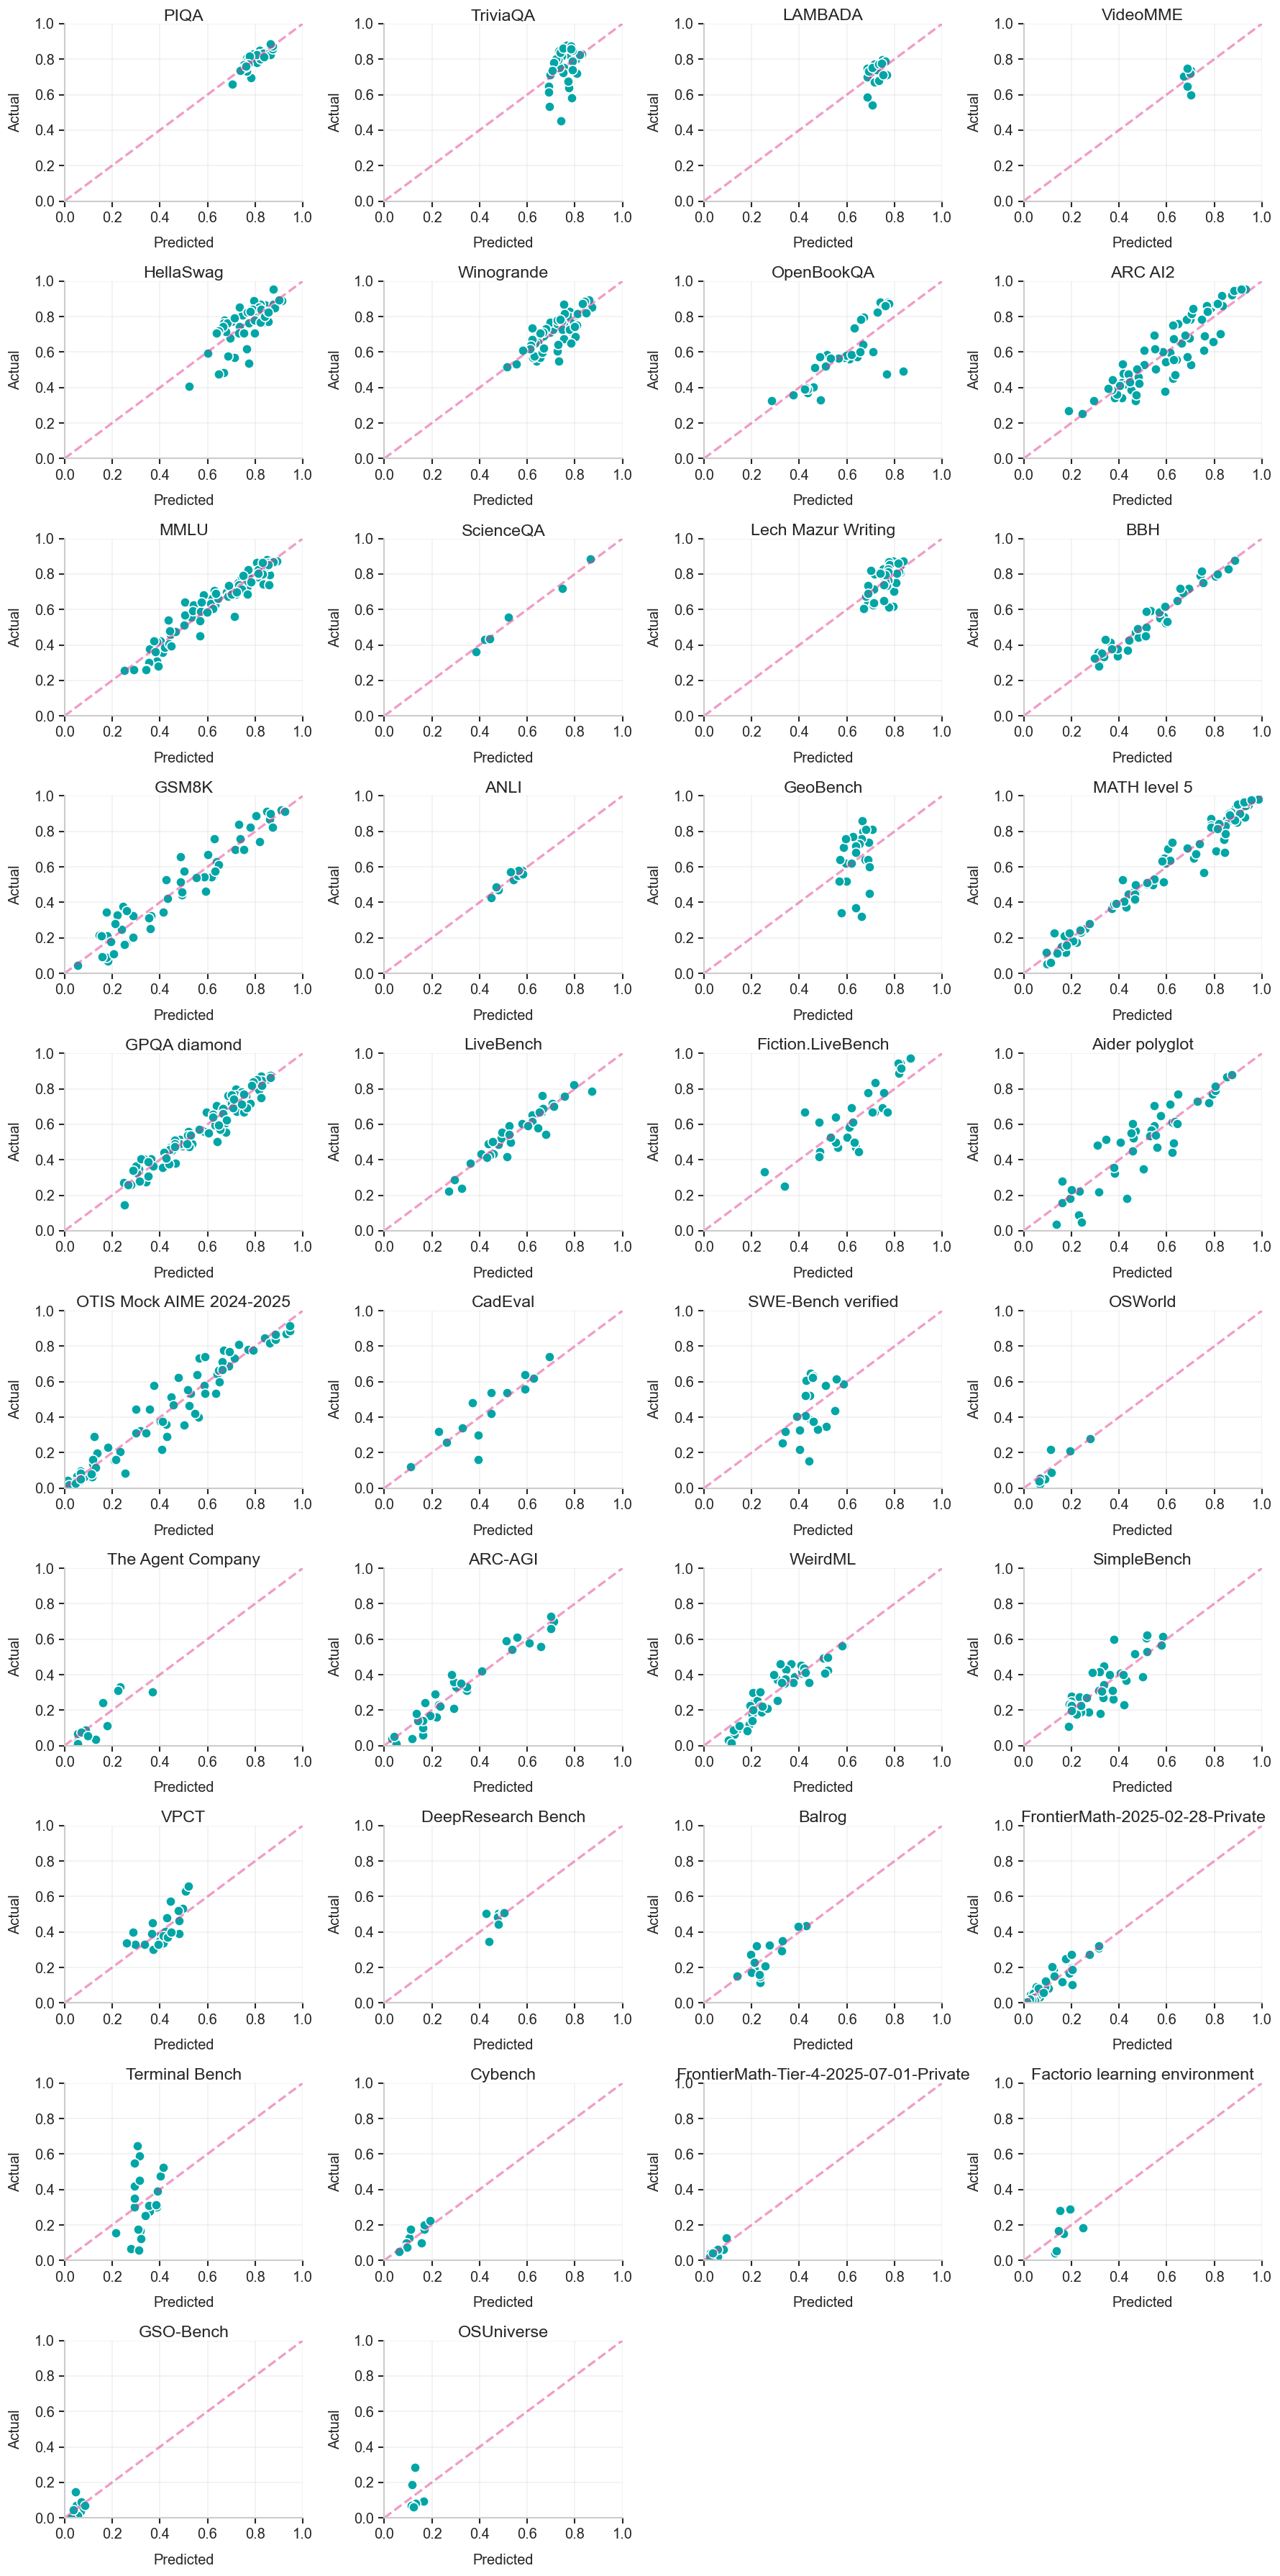

In [17]:
import matplotlib.pyplot as plt
import numpy as np


def logistic(x):
    return 1.0 / (1.0 + np.exp(-x))


# Get unique benchmarks
benchmarks = df_db1["benchmark_name"].unique()

# Create subplots
n_benchmarks = len(benchmarks)
n_cols = 4
n_rows = (n_benchmarks + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 3))
axes = axes.flatten()

# Loop through each benchmark
for idx, benchmark in enumerate(benchmarks):
    ax = axes[idx]

    # Get data for this benchmark
    bench_data = df1[df1["benchmark"] == benchmark].copy()

    # Get benchmark parameters
    bench_params = df_db1[df_db1["benchmark_name"] == benchmark].iloc[0]
    D = bench_params["estimated_difficulty"]
    alpha = bench_params["estimated_slope"]

    # Merge with model capabilities
    bench_data = bench_data.merge(
        df_cm1[["model", "estimated_capability"]], on="model", how="left"
    )

    # Calculate predicted performance
    bench_data["predicted"] = logistic(alpha * (bench_data["estimated_capability"] - D))

    # Plot
    ax.scatter(
        bench_data["predicted"],
        bench_data["performance"],
        alpha=1,
        s=64,
        edgecolors="white",
    )
    ax.plot([0, 1], [0, 1], "--", alpha=0.5, color=colors[1])
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title(benchmark)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

# Hide unused subplots
for idx in range(n_benchmarks, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.savefig(
    "outputs/model_fit/benchmark_fit_scatter_grid.pdf", dpi=300, bbox_inches="tight"
)
# plt.savefig('outputs/figures/figure-19.svg', format='svg')

plt.show()

# Figures for blog post and video

## Comparing three benchmark sigmoids

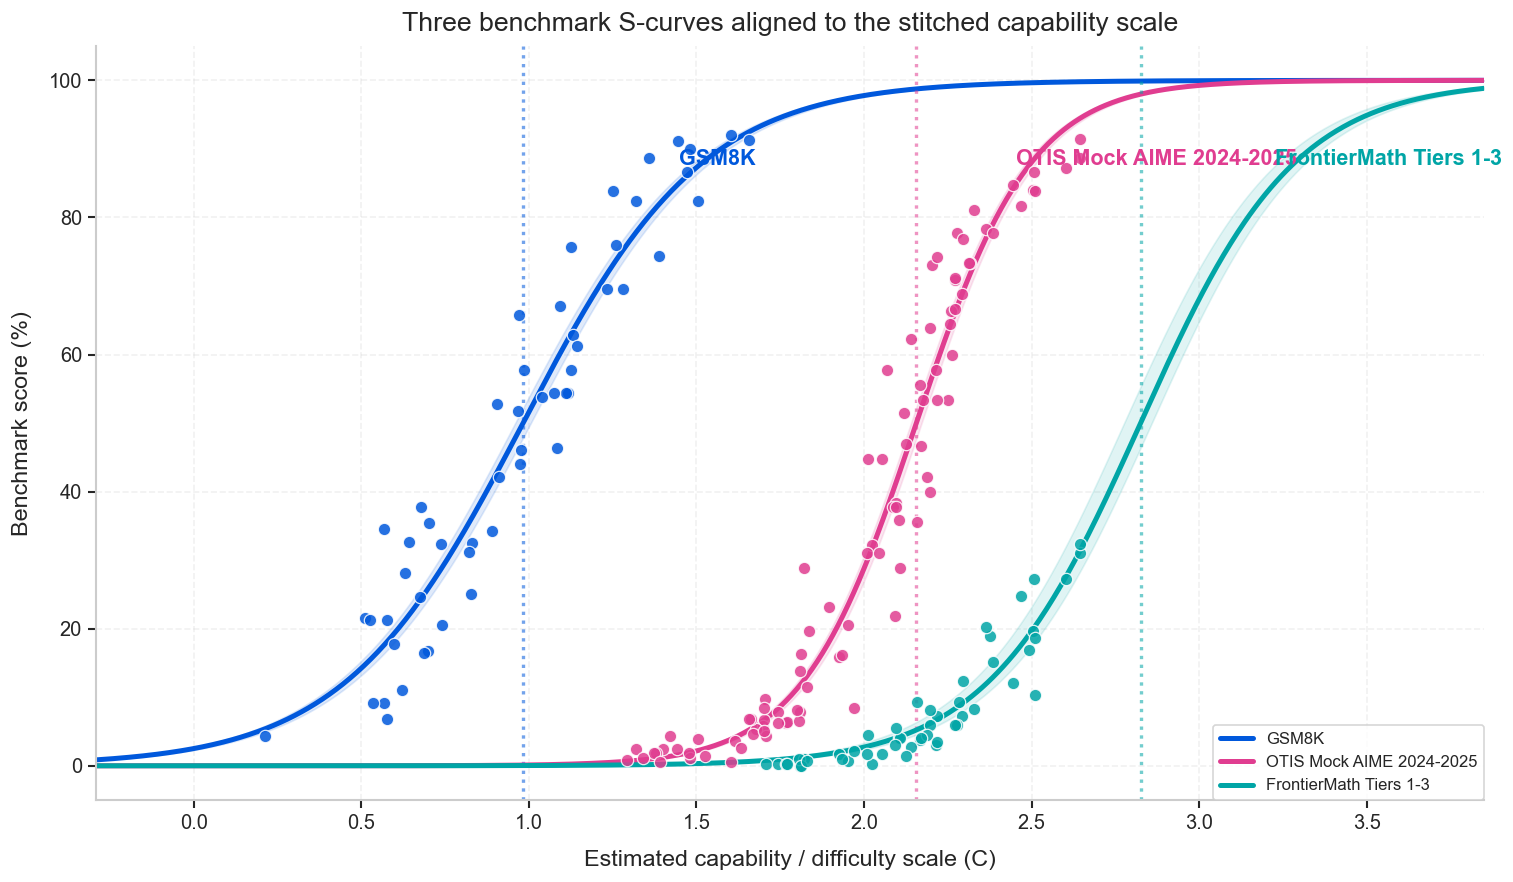

In [18]:
# ── Benchmark S-curves for GSM8K, OTIS Mock AIME, and FrontierMath ──
def _def_logistic(x):
    return 1.0 / (1.0 + np.exp(-np.clip(x, -500, 500)))


target_benchmarks = [
    {"name": "GSM8K", "label": "GSM8K", "color": colors[4]},
    {
        "name": "OTIS Mock AIME 2024-2025",
        "label": "OTIS Mock AIME 2024-2025",
        "color": colors[1],
    },
    {
        "name": "FrontierMath-2025-02-28-Private",
        "label": "FrontierMath Tiers 1-3",
        "color": colors[0],
    },
]

cap_min = df_cm1["estimated_capability"].min()
cap_max = df_cm1["estimated_capability"].max()
x_pad = 0.35
x_grid = np.linspace(cap_min - x_pad, 3.5 + x_pad, 800)

# Lookup table for difficulty error bars if they have been computed earlier
if (
    isinstance(globals().get("difficulty_errors"), pd.DataFrame)
    and "benchmark_name" in difficulty_errors.columns
):
    difficulty_error_lookup = difficulty_errors.set_index("benchmark_name").to_dict(
        "index"
    )
else:
    difficulty_error_lookup = {}

fig, ax = plt.subplots(figsize=(13, 7.5))

for bench in target_benchmarks:
    bench_row = df_db1[df_db1["benchmark_name"] == bench["name"]]
    if bench_row.empty:
        print(f"⚠️ Benchmark '{bench['name']}' not found in df_db1.")
        continue
    params = bench_row.iloc[0]
    D = params["estimated_difficulty"]
    alpha = params["estimated_slope"]

    bench_scores = (
        df1[df1["benchmark"] == bench["name"]]
        .merge(df_cm1[["model", "estimated_capability"]], on="model", how="left")
        .dropna(subset=["performance", "estimated_capability"])
    )
    if bench_scores.empty:
        print(f"⚠️ No model scores available for '{bench['name']}'.")
        continue

    curve = _def_logistic(alpha * (x_grid - D)) * 100
    ax.plot(x_grid, curve, color=bench["color"], linewidth=3, label=bench["label"])

    err_row = difficulty_error_lookup.get(bench["name"])
    if err_row is not None:
        lower = _def_logistic(alpha * (x_grid - (D + err_row["error_plus"]))) * 100
        upper = _def_logistic(alpha * (x_grid - (D - err_row["error_minus"]))) * 100
        ax.fill_between(x_grid, lower, upper, color=bench["color"], alpha=0.12)

    ax.scatter(
        bench_scores["estimated_capability"],
        bench_scores["performance"] * 100,
        s=55,
        color=bench["color"],
        edgecolors="white",
        linewidth=0.75,
        alpha=0.85,
        zorder=3,
    )

    ax.axvline(D, color=bench["color"], linestyle=":", alpha=0.55)

    # Annotate each curve near its high-accuracy region
    try:
        text_x = D + np.log(0.85 / 0.15) / alpha
    except ZeroDivisionError:
        text_x = D
    text_x = np.clip(text_x, x_grid.min(), x_grid.max())
    text_y = _def_logistic(alpha * (text_x - D)) * 100 + 2
    ax.text(
        text_x,
        text_y,
        bench["label"],
        color=bench["color"],
        fontsize=13,
        fontweight="semibold",
        ha="left",
        va="bottom",
    )

ax.set_xlabel("Estimated capability / difficulty scale (C)", fontsize=14)
ax.set_ylabel("Benchmark score (%)", fontsize=14)
ax.set_ylim(-5, 105)
ax.set_xlim(x_grid.min(), x_grid.max())
ax.set_title(
    "Three benchmark S-curves aligned to the stitched capability scale", fontsize=16
)
ax.grid(True, which="major", linestyle="--", alpha=0.3)
ax.legend(loc="lower right")

plt.tight_layout()
plt.savefig(
    "outputs/model_fit/three_benchmark_s_curves.svg", dpi=300, bbox_inches="tight"
)
plt.show()

## Model capabilities over time with error bars (run the section on error bars first)

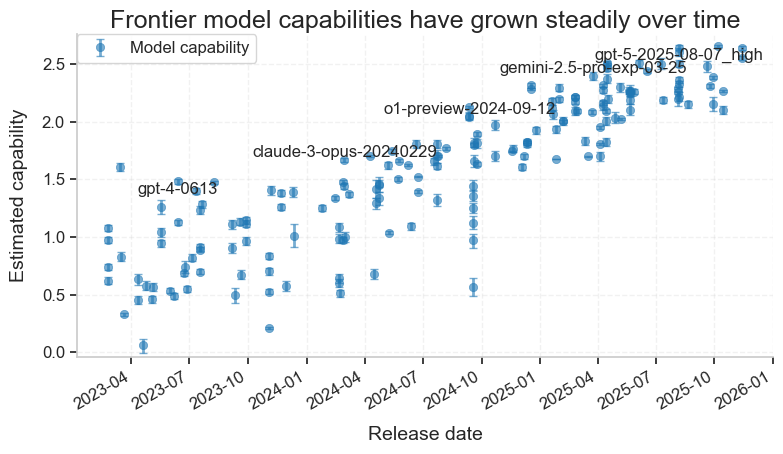

In [19]:
cap_df_with_errors = df_cm1.merge(
    capability_errors[["model", "error_minus", "error_plus"]], on="model", how="left"
)

# Prepare data
cap_df_with_errors["date_obj"] = pd.to_datetime(cap_df_with_errors["date"])
cap_df_with_errors.sort_values("date_obj", inplace=True, ignore_index=True)
cap_dates_num = mdates.date2num(cap_df_with_errors["date_obj"])
cap_values = cap_df_with_errors["estimated_capability"]

fig, ax = plt.subplots(figsize=(8, 4.7), dpi=100)

marker_px = 8
marker_points = marker_px * 72 / fig.dpi

# Plot with error bars
ax.errorbar(
    cap_dates_num,
    cap_values,
    yerr=[cap_df_with_errors["error_minus"], cap_df_with_errors["error_plus"]],
    fmt="o",
    markersize=6,
    capsize=3,
    capthick=1,
    color="tab:blue",
    ecolor="tab:blue",
    alpha=0.6,
    label="Model capability",
)

annotate_models = {
    "gpt-5-2025-08-07_high",
    "claude-opus-4-20250514_32K",
    # "grok-4-0709",
    "gpt-4-0613",
    "claude-3-opus-20240229",
    "gemini-2.5-pro-exp-03-25",
    "o1-preview-2024-09-12",
}

for i, (d, y, name) in enumerate(
    zip(cap_dates_num, cap_values, cap_df_with_errors["model"])
):
    if name not in annotate_models:
        continue
    y_offset = 0.05 if i % 2 == 0 else -0.05
    va = "bottom" if i % 2 == 0 else "top"
    ax.annotate(
        name,
        xy=(d, y),
        xytext=(0, y_offset),
        textcoords="offset points",
        ha="center",
        va=va,
        fontsize=12,
    )

# Axes cosmetics
ax.set_xlabel("Release date", fontsize=14)
ax.set_ylabel("Estimated capability", fontsize=14)
ax.set_title("Frontier model capabilities have grown steadily over time", fontsize=18)

ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
fig.autofmt_xdate()

min_y = min(cap_values.min(), cap_values.min()) - 0.1
max_y = max(cap_values.max(), cap_values.max()) + 0.1
ax.set_ylim(min_y, max_y)

ax.grid(True, linestyle="--", alpha=0.3)
ax.legend(fontsize=12)

plt.tight_layout()
plt.savefig("outputs/model_fit/capabilities_with_error_bars.pdf")
plt.savefig("outputs/model_fit/capabilities_with_error_bars.svg", format="svg")
plt.show()